In [1]:
#jupyter nbconvert --to script full_notebook.ipynb
#! Ver cómo cambiar el hyperband para que busque más configuraciones si saturan. O para que descarte las que saturan a una sola clase.
#! Comparar con lo que encuentra Random Search y Grid search.
#! El number of estimators del random forest, hacer una especie de early stopping hasta el máximo en el que se hizo el hpo

In [2]:
# # Remove any existing log files
# import os
# import glob
# import logging

# # Reset logger to avoid any issues with permissions
# logging.shutdown()
# # Remove loggers
# for log_file in glob.glob("*.log"):
#     os.remove(log_file)



# 0. Setup and Configuration

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # For confusion matrix heatmap
from scipy.stats import randint, uniform, loguniform # Ensure loguniform is imported if used
import os
import json
import time
from datetime import datetime
import math
import logging
from tqdm import tqdm  
from IPython.display import display
#from tqdm.notebook import tqdm # Needs pip install ipywidgets
#from tqdm.auto import tqdm
import joblib # For saving/loading models efficiently

# Scikit-learn imports
from sklearn.model_selection import train_test_split, StratifiedKFold, ParameterSampler
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibratedClassifierCV
from scipy.stats import loguniform # For hyperparameter distributions
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone, BaseEstimator, ClassifierMixin
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_recall_fscore_support, roc_auc_score,
    brier_score_loss, precision_recall_curve, auc, f1_score, average_precision_score
)   
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.exceptions import NotFittedError

# Boosting models
import xgboost as xgb
from xgboost.callback import EarlyStopping
import lightgbm as lgb
from lightgbm import early_stopping

# Configure logging
logging.shutdown()
logging.basicConfig(
    filename=f'models_{datetime.now().strftime("%d_%H-%M-%S")}.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    force=True
)
# Prevent logs from being printed to console
logging.getLogger().handlers = [h for h in logging.getLogger().handlers if isinstance(h, logging.FileHandler)]

## 1. Loading Dataset & Feature Selection

- Group 1: Morphology (magnitudes with errors).
- Group 2: Photometry (magnitudes with errors).
- Group 3: Combined morphology and photometry.

In [4]:
# Read the df
df = pd.read_csv('data/match_alhambra_cosmos2020_ACS_class_0.8arcsec.csv')
logging.info(f"DataFrame created with shape: {df.shape}")
# Map ACS classification: 1 (Galaxy, Majority) -> 0, 2 (Star, minority) -> 1, 3 (Fake) -> drop
logging.info("Original class counts:")
logging.info(df['acs_mu_class'].value_counts().to_string())

# Drop fake detections (class 3)
# Drop fake detections
n_fakes = (df['acs_mu_class'] == 3).sum()
logging.info(f"Number of fake detections (class 3): {n_fakes}")
df = df[df['acs_mu_class'] != 3]

# Map classifications
df['acs_mu_class'] = df['acs_mu_class'].map({1: 0, 2: 1})

logging.info("After dropping fakes and mapping classes (0: Galaxy, 1: Star):")
logging.info(df['acs_mu_class'].value_counts().to_string())

In [5]:
# Input features

# --- Modeling features ---

# 1. ALHAMBRA Morphology Features (SExtractor-based)
morphology_features = [
    'area', 'fwhm', 'stell', 
    'ell', #'a', 'b', #'theta', #a,b son fwhm y ell. Theta no da info.
    'rk', 
    'rf'
]

morphology_err = [
    's2n'
]

morphology_mags_errors = morphology_features + morphology_err

# 2. ALHAMBRA Photometry (Optical + NIR + Synthetic)
OPTICAL_MAG_COLS = [
    'F365W', 'F396W', 'F427W', 'F458W', 'F489W', 'F520W', 'F551W',
    'F582W', 'F613W', 'F644W', 'F675W', 'F706W', 'F737W', 'F768W',
    'F799W', 'F830W', 'F861W', 'F892W', 'F923W', 'F954W'
]
photometry_magnitudes = (
    OPTICAL_MAG_COLS +
    ['J', 'H', 'KS', 'F814W']
)

OPTICAL_ERR_COLS = [
    'dF365W', 'dF396W', 'dF427W', 'dF458W', 'dF489W', 'dF520W', 'dF551W',
    'dF582W', 'dF613W', 'dF644W', 'dF675W', 'dF706W', 'dF737W', 'dF768W',
    'dF799W', 'dF830W', 'dF861W', 'dF892W', 'dF923W', 'dF954W'
]
photometry_uncertainties = (
    OPTICAL_ERR_COLS +
    ['dJ', 'dH', 'dKS', 'dF814W']
)

photometry_mags_errors = photometry_magnitudes + photometry_uncertainties

# Target from acs
target_variable = ['acs_mu_class'] # The COSMOS classification label to predict

# --- Non-Modeling features ---

# ALHAMBRA Photometric Redshift & Derived Features (BPZ-based)
redshift_magnitudes = [
    'zb_1', 'zb_Min_1', 'zb_Max_1', 'Tb_1',
    'z_ml', 't_ml',
    'Stell_Mass_1', 'M_Abs_1', 'MagPrior'
]

redshift_uncertainties = [
    'Odds_1', 'Chi2'
]

redshift_mags_errors = redshift_magnitudes + redshift_uncertainties

# ALHAMBRA Quality/Auxiliary Features (per-band quality etc.)
OPTICAL_IRMS_COLS = [
    'irms_F365W', 'irms_F396W', 'irms_F427W', 'irms_F458W', 'irms_F489W',
    'irms_F520W', 'irms_F551W', 'irms_F582W', 'irms_F613W', 'irms_F644W',
    'irms_F675W', 'irms_F706W', 'irms_F737W', 'irms_F768W', 'irms_F799W',
    'irms_F830W', 'irms_F861W', 'irms_F892W', 'irms_F923W', 'irms_F954W'
]
quality_aux_features = (
    ['nfobs'] +
    OPTICAL_IRMS_COLS +
    ['irms_J', 'irms_H', 'irms_KS', 'irms_F814W']
)

# Flags and identifiers

non_modeling_identifiers = ['ID_1', 'id_2'] # ALHAMBRA ID, COSMOS ID

non_modeling_astrometry = [
    'RA_1', 'Dec_1', 'x', 'y', # ALHAMBRA Astrometry
    'ra_2', 'dec_2',          # COSMOS Astrometry
    'Separation'              # Matching Quality
]

non_modeling_flags = [
    'photoflag', 'xray', 'PercW', 'Satur_Flag', # ALHAMBRA Object/Photometry Flags
    'irms_OPT_Flag', 'irms_NIR_Flag'           # ALHAMBRA Overall Quality Flags
]

alhambra_prediction = ['Stellar_Flag'] # ALHAMBRA's own classification

non_modeling_aperture_mags = [ # Specific aperture mags, usually use total mags
    'F814W_3arcs', 'dF814W_3arcs', 'F814W_3arcs_corr'
]

non_modeling_cosmos_features = [ # Measurements/flags derived from COSMOS data (HST, HSC, VISTA...)
    'model_flag',
    'flag_hsc', 'flag_supcam', 'flag_udeep', 'flag_uvista',
    'hsc_r_mag', 'hsc_r_magerr', 'hsc_r_valid',
    'hsc_i_mag', 'hsc_i_magerr', 'hsc_i_valid',
    'uvista_j_mag', 'uvista_j_magerr', 'uvista_j_valid',
    'uvista_ks_mag', 'uvista_ks_magerr', 'uvista_ks_valid',
    'acs_f814w_mag', 'acs_f814w_magerr',
    'acs_fwhm_world', 'acs_mu_max',
    'solution_model' # This is categorical, but still COSMOS-derived info
]




# Storing features
feature_sets = {
        # --- Potential Input Feature Sets ---
        'morphology_only': morphology_mags_errors,
        'photometry_magnitudes_only': photometry_magnitudes,
        'photometry_mags_errors': photometry_mags_errors,
        'photometry_plus_morphology': photometry_mags_errors + morphology_mags_errors,
        'photometry_no_redshift': photometry_mags_errors + morphology_mags_errors + quality_aux_features,
        'redshift_only': redshift_mags_errors,
        'full_alhambra_all': (morphology_mags_errors +
                            photometry_mags_errors +
                            redshift_mags_errors + 
                            quality_aux_features),

        # --- Excluded Feature Sets ---
        'non_modeling_identifiers': non_modeling_identifiers,
        'non_modeling_astrometry': non_modeling_astrometry,
        'non_modeling_flags': non_modeling_flags,
        'non_modeling_aperture_mags': non_modeling_aperture_mags,
        'non_modeling_cosmos_features': non_modeling_cosmos_features,
        'alhambra_prediction': alhambra_prediction,
        'target_variable': target_variable
    }

# Groups of features for modeling
groups = {
        'group_1': feature_sets.get('morphology_only', []) + feature_sets.get('target_variable', []),
        'group_2': feature_sets.get('photometry_mags_errors', []) + feature_sets.get('target_variable', []),
        'group_3': (feature_sets.get('morphology_only', []) +
                   feature_sets.get('photometry_mags_errors', []) +
                   feature_sets.get('target_variable', []))
    }

# --- Function to get a specific feature set ---

def get_feature_set(df, set_name, groups = groups):
    """
    Selects columns from a DataFrame based on a predefined feature set name,
    including six specific groups defined by combinations of morphology,
    photometry magnitudes, uncertainties, and redshift features.

    Args:
        df (pd.DataFrame): The input DataFrame.
        set_name (str): The name of the desired feature set group:
                        'group_1' to 'group_6' as defined below.

    Returns:
        pd.DataFrame: A DataFrame containing only the columns
                      belonging to the specified feature set group.
                      Returns an empty DataFrame if no columns are found.
    """

    if set_name not in groups:
        raise ValueError(f"Feature set group '{set_name}' not defined. "
                         f"Available groups: {list(groups.keys())}")

    required_cols_in_set = groups[set_name]

    # Find which of these columns actually exist in the DataFrame
    available_cols = [col for col in required_cols_in_set if col in df.columns]

    # Warn if some columns from the set definition are missing
    missing_cols = [col for col in required_cols_in_set if col not in available_cols]
    if missing_cols:
        print(f"Warning: The following columns defined for feature set group '{set_name}'"
              f" were not found in the DataFrame and will be excluded: {missing_cols}")

    if not available_cols:
        print(f"Warning: No columns for feature set group '{set_name}' found in the DataFrame.")
        return pd.DataFrame()  # Return empty DataFrame

    print(f"Selecting feature set group '{set_name}' with {len(available_cols)} columns.")
    return df[available_cols]


## 2. Data Preprocessing and Splitting

In [6]:
# Data splitting parameters
TEST_SIZE = 0.20 # Test set proportion
VAL_SIZE = 0.20 # Validation set proportion
CAL_SIZE = 0.00 # Calibration set proportion
# Train size will be 1 - (TEST_SIZE + VAL_SIZE + CAL_SIZE)

TARGET_COLUMN = feature_sets.get('target_variable', [])[0]
RANDOM_SEED = 33 # For reproducibility

# Model saving directory
MODEL_DIR = "trained_models"
os.makedirs(MODEL_DIR, exist_ok=True)

# Data splitting strategy ('stratified' or 'random')
SPLIT_STRATEGY = 'stratified' # Recommended for imbalanced datasets


In [7]:
# --- Data Cleaning ---
def clean_data(df, feature_group, target_column, logger=logging):
    """
    Cleans the input DataFrame by selecting features for the given group,
    dropping NaNs, and separating features and target.

    Args:
        df (pd.DataFrame): The input DataFrame.
        feature_group (str): The feature group to use (e.g., 'group_1', 'group_2', etc.).
        target_column (str): The name of the target column.
        logger (logging.Logger): Logger for info and error messages.

    Returns:
        X (pd.DataFrame): Cleaned feature DataFrame.
        y (pd.Series): Target variable.
        df_clean (pd.DataFrame): The cleaned DataFrame (features + target).
    """
    logger.info(f"Original dataset size: {df.shape}")

    # Get the feature columns for the selected group using get_feature_set
    df_clean = get_feature_set(df, feature_group).dropna().copy()
    logger.info(f"Dataset size after dropping NaNs: {df_clean.shape}")

    # Ensure target_column is defined correctly
    if target_column not in df_clean.columns:
        raise KeyError(f"Target column '{target_column}' not found in the cleaned DataFrame columns: {df_clean.columns.tolist()}")

    # Log value counts for target
    logger.info(f"Value counts for target:\n1 (Star): {(df_clean[target_column] == 1).sum()}\n0 (Galaxy): {(df_clean[target_column] == 0).sum()}")

    # Separate features (X) and target (y) for the cleaned DataFrame
    X = df_clean.drop(columns=[target_column])
    y = df_clean[target_column]
    return X, y, df_clean

# Example usage:
# X, y, df_clean = clean_data(df, feature_group='group_7', target_column=TARGET_COLUMN, logger=logging)

In [8]:
# --- Data Splitting ---
def split_data(X, y):
    """
    Splits the data into train, validation, test, and calibration sets according to the global
    split proportions and strategy. Uses global variables:
        - TEST_SIZE, VAL_SIZE, CAL_SIZE, SPLIT_STRATEGY, RANDOM_SEED

    The logic and split order is identical to the original code.

    Args:
        X (pd.DataFrame): Feature DataFrame.
        y (pd.Series): Target variable.

    Returns:
        (X_train, y_train, X_val, y_val, X_test, y_test, X_cal, y_cal): tuple of splits.
    """
    logging.info(f"Splitting data using '{SPLIT_STRATEGY}' strategy...")

    # --- Validate Proportions ---
    if not (0 <= TEST_SIZE <= 1 and 0 <= VAL_SIZE <= 1 and 0 <= CAL_SIZE <= 1):
        raise ValueError("Split proportions (TEST_SIZE, VAL_SIZE, CAL_SIZE) must be between 0 and 1.")

    TRAIN_SIZE = 1.0 - TEST_SIZE - VAL_SIZE - CAL_SIZE
    if not (0 <= TRAIN_SIZE <= 1):
        raise ValueError(f"Calculated TRAIN_SIZE ({TRAIN_SIZE:.3f}) is invalid. Sum of TEST_SIZE, VAL_SIZE, and CAL_SIZE must be between 0 and 1.")

    if not np.isclose(TRAIN_SIZE + TEST_SIZE + VAL_SIZE + CAL_SIZE, 1.0):
        # This check might be redundant given the calculation of TRAIN_SIZE, but good for safety.
        raise ValueError("Sum of split proportions must be equal to 1.")

    if np.isclose(TRAIN_SIZE, 0) and (np.isclose(VAL_SIZE, 0) or np.isclose(TEST_SIZE, 0) or np.isclose(CAL_SIZE, 0)):
        # Avoid scenarios where train is 0 but other splits are also 0, leading to ambiguity.
        # If only train is 0, it might be valid in some rare cases, but usually requires at least one other non-zero split.
        # Let's enforce Train > 0 for typical ML workflows.
        # If you need zero training data, adjust this check.
        logging.warning("TRAIN_SIZE is zero or near zero. Ensure this is intended.")
        if TRAIN_SIZE < 0: # Definitely an error
            raise ValueError("TRAIN_SIZE cannot be negative.")
        # Allow TRAIN_SIZE = 0 only if explicitly handled later, otherwise raise error?
        # For now, let's proceed but log a warning. If TRAIN_SIZE must be > 0, uncomment the raise below.
        # raise ValueError("TRAIN_SIZE must be greater than 0 for typical model training.")

    logging.info(f"Target split ratios: Train={TRAIN_SIZE:.2f}, Val={VAL_SIZE:.2f}, Test={TEST_SIZE:.2f}, Cal={CAL_SIZE:.2f}")

    # --- Initialize Splits ---
    # Use iloc[0:0] to create empty DataFrames/Series with the same columns/dtype
    empty_X = X.iloc[0:0]
    empty_y = y.iloc[0:0]
    X_train, y_train = empty_X.copy(), empty_y.copy()
    X_val, y_val = empty_X.copy(), empty_y.copy()
    X_test, y_test = empty_X.copy(), empty_y.copy()
    X_cal, y_cal = empty_X.copy(), empty_y.copy()

    # Temporary variables for sequential splitting
    X_remaining, y_remaining = X.copy(), y.copy() # Use copies to avoid modifying original X, y

    # --- Stratification Option ---
    # Define stratify_func only once
    def get_stratify_array(y_arr):
        return y_arr if SPLIT_STRATEGY == 'stratified' and not y_arr.empty else None

    # --- First Split: Train vs. Remainder (Val + Test + Cal) ---
    val_test_cal_size = VAL_SIZE + TEST_SIZE + CAL_SIZE

    if np.isclose(val_test_cal_size, 0): # Only Train set needed
        X_train, y_train = X_remaining, y_remaining
        logging.info("All data assigned to Train set (Val, Test, Cal sizes are 0).")
        X_remaining, y_remaining = empty_X.copy(), empty_y.copy() # No remainder
    elif np.isclose(TRAIN_SIZE, 0): # No Train set needed
        logging.info("Train set is empty (TRAIN_SIZE=0). Remainder passed to next splits.")
        # X_remaining, y_remaining already hold all data
    else: # Split Train vs Remainder
        split_test_size = val_test_cal_size # Proportion of remainder relative to total (1.0)
        X_train, X_remaining, y_train, y_remaining = train_test_split(
            X_remaining, y_remaining,
            test_size=split_test_size,
            random_state=RANDOM_SEED,
            stratify=get_stratify_array(y_remaining)
        )
    logging.info(f"Train set shape: {X_train.shape}")

    # --- Second Split: Val vs. Remainder (Test + Cal) ---
    if not X_remaining.empty:
        test_cal_size = TEST_SIZE + CAL_SIZE
        # Denominator for relative size calculation: size of the current remaining pool
        current_remaining_size_frac = VAL_SIZE + test_cal_size # = val_test_cal_size

        if np.isclose(VAL_SIZE, 0): # No Val set, pass remainder to next stage
            X_temp2, y_temp2 = X_remaining, y_remaining # Remainder is Test + Cal
            logging.info("Validation set is empty (VAL_SIZE=0).")
        elif np.isclose(test_cal_size, 0): # Only Val set left in remainder
            X_val, y_val = X_remaining, y_remaining
            X_temp2, y_temp2 = empty_X.copy(), empty_y.copy() # No data left for Test/Cal
            logging.info(f"Validation set shape: {X_val.shape}")
        else: # Split Val vs (Test + Cal)
            # Proportion of (Test + Cal) relative to (Val + Test + Cal)
            split_test_size = test_cal_size / current_remaining_size_frac
            X_val, X_temp2, y_val, y_temp2 = train_test_split(
                X_remaining, y_remaining,
                test_size=split_test_size,
                random_state=RANDOM_SEED,
                stratify=get_stratify_array(y_remaining)
            )
            logging.info(f"Validation set shape: {X_val.shape}")
    else: # No data remaining after train split
        X_temp2, y_temp2 = empty_X.copy(), empty_y.copy()
        if not np.isclose(VAL_SIZE, 0): # Log only if Val set was expected
            logging.info("Validation set is empty (no data remaining after train split).")

    # --- Third Split: Test vs. Cal ---
    if not X_temp2.empty:
        # Denominator for relative size calculation: size of the current remaining pool
        current_remaining_size_frac = TEST_SIZE + CAL_SIZE # = test_cal_size

        if np.isclose(CAL_SIZE, 0): # No Cal set, remainder is Test
            X_test, y_test = X_temp2, y_temp2
            logging.info("Calibration set is empty (CAL_SIZE=0).")
        elif np.isclose(TEST_SIZE, 0): # Only Cal set left in remainder
            X_cal, y_cal = X_temp2, y_temp2
            logging.info("Test set is empty (TEST_SIZE=0).")
        else: # Split Test vs Cal
            # Proportion of Cal relative to (Test + Cal)
            split_test_size = CAL_SIZE / current_remaining_size_frac
            X_test, X_cal, y_test, y_cal = train_test_split(
                X_temp2, y_temp2,
                test_size=split_test_size,
                random_state=RANDOM_SEED,
                stratify=get_stratify_array(y_temp2)
            )
            # Logging shapes done after the if/else block
    else: # No data remaining for Test/Cal split
        if not (np.isclose(TEST_SIZE, 0) and np.isclose(CAL_SIZE, 0)): # Log only if Test or Cal were expected
            logging.info("Test and Calibration sets are empty (no data remaining for final split).")

    # Log final shapes for Test and Cal
    logging.info(f"Test set shape: {X_test.shape}")
    logging.info(f"Calibration set shape: {X_cal.shape}")

    # --- Verification and Final Logging ---
    total_len = len(X_train) + len(X_val) + len(X_test) + len(X_cal)
    original_len = len(X)

    if total_len != original_len:
        # Calculate actual proportions based on lengths
        actual_train = len(X_train) / original_len if original_len > 0 else 0
        actual_val = len(X_val) / original_len if original_len > 0 else 0
        actual_test = len(X_test) / original_len if original_len > 0 else 0
        actual_cal = len(X_cal) / original_len if original_len > 0 else 0
        logging.warning(f"Total split length ({total_len}) does not exactly match original length ({original_len}). "
                        f"This can happen with stratification or rounding. "
                        f"Target proportions: Train={TRAIN_SIZE:.3f}, Val={VAL_SIZE:.3f}, Test={TEST_SIZE:.3f}, Cal={CAL_SIZE:.3f}. "
                        f"Actual proportions: Train={actual_train:.3f}, Val={actual_val:.3f}, Test={actual_test:.3f}, Cal={actual_cal:.3f}")
    else:
        logging.info("Split lengths verification successful.")

    logging.info("Data splitting complete.")

    # Log distributions, handling empty sets
    def log_distribution(name, y_set):
        if y_set.empty:
            logging.info(f"{name} target distribution: Set is empty.")
        else:
            try:
                # Use normalize=True, handle potential division by zero if counts are zero (though unlikely if not empty)
                counts = y_set.value_counts()
                dist = counts / counts.sum() if counts.sum() > 0 else counts
                logging.info(f"{name} target distribution:\n{dist}")
                # Log absolute counts as well for clarity
                logging.info(f"{name} target counts:\n{counts}")
            except Exception as e:
                logging.error(f"Could not calculate distribution for {name}: {e}")
                # Attempt to log raw value counts even if normalization fails
                try:
                    logging.info(f"{name} raw value counts:\n{y_set.value_counts()}")
                except Exception as e_raw:
                    logging.error(f"Could not get raw value counts for {name}: {e_raw}")

    log_distribution("Train", y_train)
    log_distribution("Validation", y_val)
    log_distribution("Test", y_test)
    log_distribution("Calibration", y_cal)

    return X_train, y_train, X_val, y_val, X_test, y_test, X_cal, y_cal

# 3. Implementation

### Hyperparameter Optimization via Hyperband

In [9]:
# ==============================================================================
#                      DEFINITIVE HPO FUNCTIONS BLOCK
# ==============================================================================

# --- Internal Helper for Hyperband ---
def _train_and_eval(model_class, params,
                    X_train, y_train, X_val, y_val,
                    resource, resource_type,
                    scoring_func, random_state):
    """Internal helper function to train and evaluate a single configuration for Hyperband."""
    try:
        model = model_class(**params)
        fit_duration = 0.0
        start_fit = time.time()

        if resource_type == 'data_fraction':
            # If the resource is 1.0, use the full dataset directly.
            # Otherwise, perform the split.
            if np.isclose(resource, 1.0):
                X_subset, y_subset = X_train, y_train
            else:
                # Use a fraction of the data for training
                train_size = resource if resource > 0 else 0.1 # Ensure non-zero train_size
                X_subset, _, y_subset, _ = train_test_split(
                    X_train, y_train, train_size=train_size, random_state=random_state, stratify=y_train
                )
            
            y_subset_np = y_subset.values if isinstance(y_subset, pd.Series) else y_subset
            model.fit(X_subset, y_subset_np)
            fit_duration = time.time() - start_fit

        elif resource_type == 'iterations':
            # Use a fraction of the iterations (n_estimators) for training
            params_iter = params.copy()
            params_iter['n_estimators'] = int(max(1, resource))
            model = model_class(**params_iter)

            current_fit_args = {}
            eval_set_for_fit = [(X_val, y_val)]

            if model_class is xgb.XGBClassifier:
                current_fit_args['eval_set'] = eval_set_for_fit
                current_fit_args['verbose'] = False

            # CORRECTED: Only one 'elif' for LightGBM
            elif model_class is lgb.LGBMClassifier:
                current_fit_args['eval_set'] = eval_set_for_fit
                # Pass the metric if it's in the HPO params, otherwise it will use the model's default
                if 'metric' in params_iter and params_iter['metric']:
                     current_fit_args['eval_metric'] = params_iter['metric']

            y_train_np = y_train.values if isinstance(y_train, pd.Series) else y_train
            model.fit(X_train, y_train_np, **current_fit_args)
            fit_duration = time.time() - start_fit

        else:
            raise ValueError("Invalid resource_type. Choose 'data_fraction' or 'iterations'.")

        # Evaluate on the full validation set
        y_pred_val = model.predict(X_val)
        y_val_np = y_val.values if isinstance(y_val, pd.Series) else y_val
        score = scoring_func(y_val_np, y_pred_val)
        return score

    except Exception as e:
        logging.error(f"Error in _train_and_eval for config {params} with resource {resource}: {e}", exc_info=False)
        return -1.0

# --- Helper function for Random and Grid Search (uses full resource) ---
def _train_and_eval_single_config(model_class, params, X_train, y_train, X_val, y_val, scoring_func, random_state):
    """Trains and evaluates a single model configuration with full resources."""
    try:
        params_to_fit = params.copy()
        if 'random_state' not in params_to_fit and hasattr(model_class(random_state=1), 'random_state'):
            params_to_fit['random_state'] = random_state
        if model_class in [SVC, RandomForestClassifier, DecisionTreeClassifier] and 'class_weight' not in params_to_fit:
            params_to_fit['class_weight'] = 'balanced'
        if model_class in [xgb.XGBClassifier, lgb.LGBMClassifier] and 'scale_pos_weight' not in params_to_fit:
            neg_count, pos_count = np.bincount(y_train)
            if pos_count > 0: params_to_fit['scale_pos_weight'] = neg_count / pos_count
        if model_class is lgb.LGBMClassifier and 'objective' not in params_to_fit:
            params_to_fit['objective'] = 'binary'
            
        model = model_class(**params_to_fit)
        
        fit_args = {}
        if model_class is xgb.XGBClassifier or model_class is lgb.LGBMClassifier:
            fit_args['eval_set'] = [(X_val, y_val)]
            if model_class is xgb.XGBClassifier: fit_args['verbose'] = False
        
        y_train_np = y_train.values if isinstance(y_train, pd.Series) else y_train
        model.fit(X_train, y_train_np, **fit_args)
        
        y_pred_val = model.predict(X_val)
        y_val_np = y_val.values if isinstance(y_val, pd.Series) else y_val
        return scoring_func(y_val_np, y_pred_val)

    except Exception as e:
        logging.error(f"Error in _train_and_eval_single_config for config {params}: {e}", exc_info=False)
        return -1.0

# --- Random Search HPO ---
def random_search_hpo(model_class, param_space, X_train, y_train, X_val, y_val, n_iter, scoring_func, random_state):
    """Performs Random Search HPO."""
    logging.info(f"--- Starting Random Search (n_iter={n_iter}) ---")
    start_time = time.time()
    param_sampler = ParameterSampler(param_space, n_iter=n_iter, random_state=random_state)
    best_score, best_params, evaluated = -1.0, None, 0
    
    for params in tqdm(param_sampler, desc="Random Search", total=n_iter, leave=False):
        score = _train_and_eval_single_config(model_class, params, X_train, y_train, X_val, y_val, scoring_func, random_state)
        if score > best_score:
            best_score, best_params = score, params
        evaluated += 1

    total_time = time.time() - start_time
    return {'best_params': best_params, 'best_score': best_score, 'total_time': total_time, 'n_configs': evaluated, 'mean_time_per_config': total_time / evaluated if evaluated > 0 else 0}

# --- Grid Search HPO ---
from sklearn.model_selection import ParameterGrid
def grid_search_hpo(model_class, grid_param_space, X_train, y_train, X_val, y_val, scoring_func, random_state):
    """Performs Grid Search HPO."""
    param_grid = list(ParameterGrid(grid_param_space))
    n_configs = len(param_grid)
    logging.info(f"--- Starting Grid Search (n_configs={n_configs}) ---")
    start_time = time.time()
    best_score, best_params = -1.0, None
    
    for params in tqdm(param_grid, desc="Grid Search", total=n_configs, leave=False):
        score = _train_and_eval_single_config(model_class, params, X_train, y_train, X_val, y_val, scoring_func, random_state)
        if score > best_score:
            best_score, best_params = score, params

    total_time = time.time() - start_time
    return {'best_params': best_params, 'best_score': best_score, 'total_time': total_time, 'n_configs': n_configs, 'mean_time_per_config': total_time / n_configs if n_configs > 0 else 0}

# --- Hyperband HPO (returns a dictionary) ---
def hyperband_hpo(model_class, param_space,
                  X_train, y_train, X_val, y_val,
                  max_resource, eta=3, resource_type='iterations', min_resource=1,
                  scoring_func=f1_score, random_state=None, config_multiplier=10):
    """Performs Hyperband HPO. MODIFIED: Returns a dictionary with detailed stats."""
    start_time = time.time()
    s_max = int(math.log(max_resource / min_resource, eta)) if max_resource > min_resource and min_resource > 0 else 0
    B = (s_max + 1) * max_resource
    logging.info(f"--- Starting Hyperband HPO ---")
    
    best_params, best_score, total_evals = None, -1.0, 0
    
    for s in range(s_max, -1, -1):
        n = int(math.ceil(B / max_resource / (s + 1)) * eta**s) * config_multiplier
        r = max_resource * eta**(-s)
        
        param_list = list(ParameterSampler(param_space, n_iter=n, random_state=random_state + s if random_state else None))
        
        for p in param_list:
             if 'random_state' not in p and hasattr(model_class(random_state=1), 'random_state'): p['random_state'] = random_state
             if model_class in [SVC, RandomForestClassifier, DecisionTreeClassifier] and 'class_weight' not in p: p['class_weight'] = 'balanced'

        for i in range(s + 1):
            n_i, r_i = len(param_list), min(r * eta**i, max_resource)
            round_scores = [( _train_and_eval(model_class, p, X_train, y_train, X_val, y_val, r_i, resource_type, scoring_func, random_state), p) for p in param_list]
            total_evals += len(round_scores)
            round_scores.sort(key=lambda x: x[0], reverse=True)
            
            if abs(r_i - max_resource) < 1e-6 and round_scores and round_scores[0][0] > best_score:
                best_score, best_params = round_scores[0][0], round_scores[0][1]

            n_keep = int(n_i / eta)
            if n_keep < 1: break
            param_list = [p for score, p in round_scores[:n_keep]]
    
    total_time = time.time() - start_time
    logging.info(f"Hyperband finished in {total_time:.2f}s. Best score: {best_score:.4f}")
    return {'best_params': best_params, 'best_score': best_score, 'total_time': total_time, 'n_configs': total_evals, 'mean_time_per_config': total_time / total_evals if total_evals > 0 else 0}

# --- HPO Comparison Orchestrator ---
def run_hpo_comparison(
    model_class, model_name,
    param_space_continuous, param_space_grid,
    X_train, y_train, X_val, y_val,
    hpo_settings, scoring_func, random_state
):
    """Runs HPO comparison and returns the overall best result."""
    # logging.info(f"\n{'='*20} Starting HPO Comparison for {model_name} {'='*20}")
    
    hyperband_res = hyperband_hpo(model_class, param_space_continuous, X_train, y_train, X_val, y_val, scoring_func=scoring_func, random_state=random_state, **hpo_settings['hyperband'])
    # random_res = random_search_hpo(model_class, param_space_continuous, X_train, y_train, X_val, y_val, scoring_func=scoring_func, random_state=random_state, **hpo_settings['random'])
    # grid_res = grid_search_hpo(model_class, param_space_grid, X_train, y_train, X_val, y_val, scoring_func=scoring_func, random_state=random_state)
    
    results_map = {"Hyperband": hyperband_res#, "Random Search": random_res, "Grid Search": grid_res
                    }
    best_method = max(results_map, key=lambda k: results_map[k]['best_score'])
    
    # logging.info(f"\n--- HPO Comparison Summary for {model_name} ---")
    # for method, res in results_map.items():
    #     logging.info(f"  Method: {method} | Best Score: {res['best_score']:.4f} | Time: {res['total_time']:.2f}s | Configs: {res['n_configs']}")
    logging.info(f"--- Overall Best Method: {best_method} (Score: {results_map[best_method]['best_score']:.4f}) ---")
    
    return {'best_params_overall': results_map[best_method]['best_params'], 'best_score_overall': results_map[best_method]['best_score'], 'best_method': best_method, 'all_results': results_map}

### Calibration (Platt Scaling/Isotonic Regression/Cross Venn Abers Predictors)


In [10]:
from raw_cvap import RawVennAbers, CVAPPredictorRaw

# --- Helper Function to Get Scores ---
def get_scores(estimator, X, score_method):
    """Gets scores from an estimator based on the specified method."""
    if score_method == 'decision_function':
        if hasattr(estimator, 'decision_function'):
            scores = estimator.decision_function(X)
            # Ensure scores are 1D for binary classification
            if scores.ndim == 2 and scores.shape[1] == 1:
                 scores = scores.flatten()
            elif scores.ndim > 1:
                 # For binary, decision_function should be 1D. If not, maybe multiclass? Raise error.
                 raise ValueError(f"decision_function returned shape {scores.shape}, expected 1D for binary classification.")
            return scores
        else:
            raise AttributeError(f"{estimator.__class__.__name__} does not have 'decision_function' method.")
    elif score_method == 'predict_proba':
        if hasattr(estimator, 'predict_proba'):
            # Return probability of the positive class (class 1)
            proba = estimator.predict_proba(X)
            if proba.shape[1] != 2:
                 raise ValueError(f"predict_proba returned shape {proba.shape}, expected (n_samples, 2)")
            return proba[:, 1]
        else:
            raise AttributeError(f"{estimator.__class__.__name__} does not have 'predict_proba' method.")
    elif score_method == 'raw_margin_xgb':
        # Check if it looks like an XGBoost model (basic check)
        # A more robust check might involve isinstance(estimator, xgboost.XGBModel) after importing xgboost
        if hasattr(estimator, 'predict') and hasattr(estimator, 'get_params') and 'objective' in estimator.get_params():
             try:
                 # XGBoost convention: predict with output_margin=True gives raw scores
                 # For binary classification, this is usually a single value per instance
                 scores = estimator.predict(X, output_margin=True)
                 return scores.flatten() # Ensure 1D
             except TypeError as e:
                  # Check if the error message specifically mentions 'output_margin'
                  if 'output_margin' in str(e):
                      raise TypeError(f"'output_margin' might not be a valid parameter for predict in this XGBoost version or configuration. Error: {e}")
                  else:
                      raise TypeError(f"Error calling predict with output_margin=True on {estimator.__class__.__name__}. Is it an XGBoost model? Original error: {e}")

        else:
             raise AttributeError(f"{estimator.__class__.__name__} might not be an XGBoost model supporting 'output_margin'.")
    elif score_method == 'raw_score_lgbm':
         # Check if it looks like a LightGBM model (basic check)
         # A more robust check might involve isinstance(estimator, lightgbm.LGBMModel) after importing lightgbm
        if hasattr(estimator, 'predict') and hasattr(estimator, 'get_params') and 'objective' in estimator.get_params():
             try:
                 # LightGBM convention: predict with raw_score=True gives raw scores
                 # For binary classification, output shape might depend on objective.
                 # Often (n_samples,) or (n_samples, 1) for binary logloss/cross_entropy
                 scores = estimator.predict(X, raw_score=True)
                 # Handle potential (n_samples, 1) output for binary
                 if scores.ndim == 2 and scores.shape[1] == 1:
                     scores = scores.flatten()
                 elif scores.ndim != 1:
                      # If multiclass raw_score=True might return (n_samples, n_classes)
                      raise ValueError(f"LightGBM raw_score returned shape {scores.shape}. Expected 1D for binary.")
                 return scores
             except TypeError as e:
                 # Check if the error message specifically mentions 'raw_score'
                 if 'raw_score' in str(e):
                      raise TypeError(f"'raw_score' might not be a valid parameter for predict in this LightGBM version or configuration. Error: {e}")
                 else:
                      raise TypeError(f"Error calling predict with raw_score=True on {estimator.__class__.__name__}. Is it a LightGBM model? Original error: {e}")
        else:
             raise AttributeError(f"{estimator.__class__.__name__} might not be a LightGBM model supporting 'raw_score'.")
    else:
        raise ValueError(f"Unsupported score_method: {score_method}. Choose 'decision_function', 'predict_proba', 'raw_margin_xgb', or 'raw_score_lgbm'.")

# --- Loading and saving models ---
def _get_save_path(model_dir: str, model_name: str, group_name: str, calibration_method: str) -> str:
    """
    Constructs the standardized file path including a group subfolder
    and ensures the target directory exists.

    Args:
        model_dir (str): The base directory for saving models.
        model_name (str): Name of the model (e.g., 'SVM').
        group_name (str): Name of the data group (e.g., 'group_1'). Used for subfolder.
        calibration_method (str): The calibration method ('platt', 'isotonic', 'cvap').

    Returns:
        str: The full, absolute path to the save file.
             Example: /path/to/models/group_1/SVM_group_1_platt.joblib

    Raises:
        OSError: If the directory cannot be created due to permissions or other OS issues.
    """
    # Define the filename (remains the same as before)
    filename = f"{model_name}_{group_name}_{calibration_method}.joblib"

    # Define the target directory path including the group subfolder
    # Use group_name as the subfolder name
    target_directory = os.path.join(model_dir, group_name)

    # Ensure the target directory exists; create it if necessary
    try:
        # os.makedirs creates parent directories as needed (like model_dir if it doesn't exist)
        # exist_ok=True prevents an error if the directory already exists
        os.makedirs(target_directory, exist_ok=True)
        logging.debug(f"Ensured directory exists: {target_directory}")
    except OSError as e:
        # Log the error and re-raise it so the calling function knows something went wrong
        logging.error(f"Could not create directory {target_directory}: {e}", exc_info=True)
        raise  # Re-raise the exception to halt execution if directory creation fails

    # Construct the full file path by joining the target directory and filename
    full_file_path = os.path.join(target_directory, filename)

    # Optional: Return absolute path for clarity, especially if model_dir might be relative
    return os.path.abspath(full_file_path)

def save_predictor(predictor_object, file_path: str, model_name: str):
    """Saves the fitted predictor object (CalibratedClassifierCV or CVAPPredictorRaw) to a file."""
    try:
        joblib.dump(predictor_object, file_path)
        logging.info(f"--- [{model_name}] Model with calibrator saved successfully to {file_path} ---")
    except Exception as e:
        logging.error(f"--- [{model_name}] Failed to save model with calibrator to {file_path}: {e} ---", exc_info=True)

def load_predictor(file_path: str, model_name: str):
    """Loads the fitted predictor object from a file."""
    if not os.path.exists(file_path):
        logging.info(f"--- [{model_name}] Predictor save file not found at {file_path}. Proceeding with training. ---")
        return None

    try:
        loaded_predictor = joblib.load(file_path)
        # Basic checks: Is it an object? Does it have predict_proba? Is it fitted?
        if loaded_predictor is not None and hasattr(loaded_predictor, 'predict_proba'):
            # Check if it appears fitted (works for CalibratedClassifierCV, need similar for CVAPPredictorRaw if available)
            try:
                # Check if the base estimator inside CalibratedClassifierCV is fitted
                if isinstance(loaded_predictor, CalibratedClassifierCV):
                     # Access the fitted base estimator(s)
                     estimators_to_check = []
                     if hasattr(loaded_predictor, 'calibrated_classifiers_') and loaded_predictor.calibrated_classifiers_:
                         estimators_to_check = [cc.base_estimator for cc in loaded_predictor.calibrated_classifiers_]
                     elif hasattr(loaded_predictor, 'base_estimator_'): # For older sklearn? Or if fitted directly without CV part?
                          estimators_to_check = [loaded_predictor.base_estimator_]

                     if not estimators_to_check:
                          raise ValueError("Could not find base estimator(s) in loaded CalibratedClassifierCV")

                     # Check if *all* base estimators are fitted
                     all_fitted = all(hasattr(est, "classes_") or isinstance(getattr(est, "_is_fitted", lambda: False)(), bool) for est in estimators_to_check) # Use _is_fitted where available
                     if not all_fitted:
                          logging.warning(f"--- [{model_name}] Loaded predictor from {file_path} has unfitted base estimator(s). Retraining. ---")
                          return None
                # Add check for CVAPPredictorRaw if it has a standard fitted attribute or method
                elif isinstance(loaded_predictor, CVAPPredictorRaw):
                     # Assuming CVAPPredictorRaw has a final_estimator_ that should be fitted
                     if not hasattr(loaded_predictor, 'final_estimator_') or not hasattr(loaded_predictor.final_estimator_, "classes_"):
                           logging.warning(f"--- [{model_name}] Loaded CVAPPredictorRaw from {file_path} seems incomplete or unfitted. Retraining. ---")
                           return None
                else:
                     # For other types, maybe just rely on predict_proba existing
                     pass

                logging.info(f"--- [{model_name}] Predictor loaded successfully from {file_path} ---")
                return loaded_predictor

            except (AttributeError, ValueError, TypeError) as fit_check_err:
                 logging.warning(f"--- [{model_name}] Loaded predictor from {file_path} raised error during fitted check ({fit_check_err}). Assuming invalid. Retraining. ---")
                 return None
        else:
            logging.warning(f"--- [{model_name}] Loaded object from {file_path} is not a valid predictor (None or no predict_proba). Proceeding with training. ---")
            return None
    except Exception as e:
        logging.error(f"--- [{model_name}] Failed to load predictor from {file_path}: {e}. Proceeding with training. ---", exc_info=True)
        return None


# --- Main Unified Function ---
def train_calibrate_model(base_estimator_class, best_params, X_train, y_train,
                          model_name: str,
                          group_name: str,
                          MODEL_DIR: str,
                          calibration_method='platt', # 'platt', 'isotonic', 'cvap'
                          n_splits=5, random_state=None,
                          # CVAP specific params
                          score_method='decision_function', # 'decision_function', 'predict_proba', 'raw_margin_xgb', 'raw_score_lgbm'
                          cvap_loss='log', # 'log' or 'brier' for aggregation
                          cvap_precision=None, # Precision for rounding scores in VA fit
                          # Platt/Isotonic specific params (CalibratedClassifierCV handles score method)
                         ):
    """
    Trains a base estimator and calibrates it, or loads a pre-trained/calibrated predictor.

    Saves/Loads the single fitted predictor object (CalibratedClassifierCV or CVAPPredictorRaw)
    into a file specific to the calibration method.

    Args:
        base_estimator_class: Class of the base estimator (e.g., SVC, RandomForestClassifier).
        best_params (dict): Dictionary of best hyperparameters for the base estimator.
        X_train (pd.DataFrame or np.ndarray): Training features.
        y_train (pd.Series or np.ndarray): Training labels (binary 0/1).
        model_name (str): Name of the model (e.g., 'SVM').
        group_name (str): Name of the data group (e.g., 'group_1').
        MODEL_DIR (str): Directory to save/load models.
        calibration_method (str): 'platt', 'isotonic', or 'cvap'.
        n_splits (int): Number of folds for cross-validation.
        random_state (int): Random state for reproducibility.
        score_method (str): Method for CVAP scores ('decision_function', 'predict_proba', etc.).
        cvap_loss (str): Aggregation loss for CVAP ('log' or 'brier').
        cvap_precision (int, optional): Precision for CVAP VennAbers fit.

    Returns:
        object or None:
            - Fitted predictor object with a `predict_proba` method
              (either CalibratedClassifierCV or CVAPPredictorRaw).
            - Returns None if an error occurs during training/loading or if loading fails validation.
    """
    logging.info(f"--- Preparing Model Training & Calibration ({calibration_method}) for {model_name} ({group_name}) ---")

    # --- Check for existing saved predictor first ---
    save_path = _get_save_path(MODEL_DIR, model_name, group_name, calibration_method)
    loaded_predictor = load_predictor(save_path, model_name)
    if loaded_predictor is not None:
        logging.info(f"--- Using pre-trained and calibrated predictor from {save_path} ---")
        return loaded_predictor
    # If loaded_predictor is None, load_predictor already logged the reason (not found or invalid)

    # --- Proceed with training if predictor not loaded ---
    logging.info(f"--- Starting Model Training & Calibration ({calibration_method}) ---")

    # Input Type Handling (same as before)
    if isinstance(X_train, pd.DataFrame):
        X_train_np = X_train.values
    else:
        X_train_np = np.asarray(X_train)
    if isinstance(y_train, pd.Series):
        y_train_np = y_train.values
    else:
        y_train_np = np.asarray(y_train)
    if len(np.unique(y_train_np)) != 2:
        logging.error(f"This function currently supports only binary classification. Found labels: {np.unique(y_train_np)}")
        raise ValueError(f"Binary classification required. Found labels: {np.unique(y_train_np)}")

    # Instantiate the base estimator (same as before, including SVC probability logic)
    try:
        current_params = best_params.copy()
        is_svc = issubclass(base_estimator_class, SVC)

        needs_proba = False
        # Check if base estimator *needs* predict_proba for the chosen calibration approach
        if calibration_method in ['platt', 'isotonic']:
            # CalibratedClassifierCV can use decision_function OR predict_proba.
            # It automatically uses decision_function if available, unless method='isotonic'
            # AND the base estimator only has predict_proba.
            # Forcing probability=True for SVC with Platt is common practice, though not strictly required by CCCV if decision_function exists.
            # Let's keep the original logic for SVC to be safe.
            if is_svc: needs_proba = True
        elif calibration_method == 'cvap' and score_method == 'predict_proba':
             needs_proba = True # Only if base estimator needs probability for predict_proba

        if needs_proba and is_svc and not current_params.get('probability', False):
             logging.warning(f"Setting probability=True for SVC as required by calibration setup.")
             current_params['probability'] = True
        elif needs_proba and not hasattr(base_estimator_class(**current_params), 'predict_proba'):
             # If we absolutely need predict_proba (e.g., CVAP with score_method='predict_proba')
             # and the estimator doesn't have it, it's an issue.
             logging.error(f"Configuration requires 'predict_proba' (score_method='{score_method}'), "
                            f"but {base_estimator_class.__name__} with params {current_params} might not support it.")
             # Decide whether to raise an error or just warn
             # Raising an error is safer:
             raise AttributeError(f"{base_estimator_class.__name__} does not support 'predict_proba' needed for this configuration.")
             # Alternatively, warn and proceed, hoping get_scores handles it (though it will likely fail there):
             # logging.warning(f"Score method '{score_method}' requires 'predict_proba', but {base_estimator_class.__name__} might not support it with current params. Proceeding, but check estimator capabilities.")

        base_estimator = base_estimator_class(**current_params)

    except Exception as e:
        logging.error(f"Error instantiating base estimator {base_estimator_class.__name__} with params {current_params}: {e}", exc_info=True)
        return None


    # --- Calibration Method Logic ---
    final_predictor = None # This will hold the object to be returned/saved

    try:
        if calibration_method in ['platt', 'isotonic']:
            logging.info(f"Using CalibratedClassifierCV with method='{'sigmoid' if calibration_method == 'platt' else 'isotonic'}'")

            cv_strategy = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
            # Use the instantiated base_estimator. CalibratedClassifierCV clones it internally for CV.
            # It then refits a final base estimator on all data.
            calibrator = CalibratedClassifierCV(
                base_estimator, # Pass the configured instance
                method='sigmoid' if calibration_method == 'platt' else 'isotonic',
                cv=cv_strategy,
                n_jobs=-1,
                #!ensemble=False # Default, ensures one final model refit on all data
            )

            logging.info("Fitting CalibratedClassifierCV...")
            calibrator.fit(X_train_np, y_train_np)
            # No need to set fitted_ manually, sklearn does this.
            logging.info("CalibratedClassifierCV fitting complete.")

            # The 'calibrator' object IS the final predictor we want.
            final_predictor = calibrator

            logging.info(f"--- {calibration_method.capitalize()} Calibration Training Complete ---")
            # Save the single CalibratedClassifierCV object
            save_predictor(final_predictor, save_path, model_name)
            return final_predictor


        elif calibration_method == 'cvap':
            logging.info(f"Using Cross Venn-Abers Prediction (CVAP) with score_method='{score_method}'")

            cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
            oof_scores_list, oof_y_cal_list = [], []
            fold_estimators = [] # Store fold estimators if needed later, otherwise remove

            logging.info("Generating out-of-fold scores for CVAP...")
            for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_np, y_train_np)):
                logging.debug(f"Fitting fold {fold+1}/{n_splits}")
                # Clone the original base estimator config for each fold
                est = clone(base_estimator).fit(X_train_np[train_idx], y_train_np[train_idx])
                scores = get_scores(est, X_train_np[val_idx], score_method)
                oof_scores_list.append(scores)
                oof_y_cal_list.append(y_train_np[val_idx])
                fold_estimators.append(est) # Optional: keep if needed elsewhere
            logging.info("Out-of-fold score generation complete.")

            logging.info("Fitting final base model on all data...")
            # Clone again to ensure a fresh fit on all data
            final_base_estimator = clone(base_estimator).fit(X_train_np, y_train_np)
            logging.info("Final base model fitting complete.")

            logging.info("Fitting VennAbers calibrators for each fold...")
            calibrators = [
                RawVennAbers(precision=cvap_precision).fit(scores, y_cal)
                for scores, y_cal in zip(oof_scores_list, oof_y_cal_list)
            ]
            logging.info("VennAbers fitting complete.")

            # Wrap them into CVAPPredictorRaw
            cvap_predictor = CVAPPredictorRaw(
                final_estimator_=final_base_estimator,
                calibrators_=calibrators,
                loss_=cvap_loss,
                score_method_=score_method
                # Note: CVAPPredictorRaw should internally set fitted_=True or provide predict_proba
            )
            # Manually set fitted_ flag if CVAPPredictorRaw doesn't do it
            if not hasattr(cvap_predictor, 'fitted_'):
                cvap_predictor.fitted_ = True

            final_predictor = cvap_predictor
            logging.info("--- CVAP Training Complete ---")

            # Save the single CVAPPredictorRaw object
            save_predictor(final_predictor, save_path, model_name)
            return final_predictor

        else:
            raise ValueError(f"Unknown calibration_method: {calibration_method}. Choose 'platt', 'isotonic', or 'cvap'.")

    except Exception as e:
        logging.error(f"Error during {calibration_method} calibration for {model_name}: {e}", exc_info=True)
        return None # Return None on any error during training/calibration

### Metrics

In [11]:
# --- Define Comprehensive Metrics ---

def calculate_metrics(y_true, y_pred, y_proba, model_name="Model", conf_mat = False):
    """
    Calculates a comprehensive set of classification metrics.

    Args:
        y_true (array-like): Ground truth labels.
        y_pred (array-like): Predicted labels.
        y_proba (array-like): Predicted probabilities for the positive class (class 1).
        model_name (str): Name of the model for logging.

    Returns:
        dict: A dictionary containing calculated metrics.
              Returns None if input arrays are empty or invalid.
    """
    if len(y_true) == 0 or len(y_pred) == 0 or len(y_proba) == 0:
        logging.error(f"[{model_name}] Empty input arrays provided for metric calculation.")
        return None
    if len(y_true) != len(y_pred) or len(y_true) != len(y_proba):
        logging.error(f"[{model_name}] Mismatched lengths in input arrays for metric calculation.")
        return None

    metrics = {}

    # --- Threshold-based Metrics (using y_pred) ---
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['precision'] = precision
    metrics['recall_tpr'] = recall # True Positive Rate (Sensitivity)
    metrics['f1_score'] = f1

    # Specificity (True Negative Rate)
    metrics['specificity_tnr'] = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Geometric Mean
    metrics['g_mean'] = np.sqrt(metrics['recall_tpr'] * metrics['specificity_tnr'])

    # Confusion Matrix
    metrics['confusion_matrix'] = {'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp}

    # --- Ranking/Probabilistic Metrics (using y_proba) ---
    try:
        metrics['roc_auc'] = roc_auc_score(y_true, y_proba)
    except ValueError as e:
        logging.warning(f"[{model_name}] Could not calculate ROC AUC: {e}. Setting to 0.0.")
        metrics['roc_auc'] = 0.0 # Handle cases with only one class present

    # PR AUC
    pr_curve_precision, pr_curve_recall, _ = precision_recall_curve(y_true, y_proba)
    metrics['pr_auc'] = auc(pr_curve_recall, pr_curve_precision) # Note order: recall is x, precision is y

    # Brier Score
    metrics['brier_score'] = brier_score_loss(y_true, y_proba)

    logging.info(f"--- {model_name} Metrics ---")
    logging.info(f"Accuracy: {metrics['accuracy']:.4f}")
    logging.info(f"Precision: {metrics['precision']:.4f}")
    logging.info(f"Recall (TPR): {metrics['recall_tpr']:.4f}")
    logging.info(f"Specificity (TNR): {metrics['specificity_tnr']:.4f}")
    logging.info(f"F1-Score: {metrics['f1_score']:.4f}")
    logging.info(f"G-Mean: {metrics['g_mean']:.4f}")
    logging.info(f"ROC AUC: {metrics['roc_auc']:.4f}")
    logging.info(f"PR AUC: {metrics['pr_auc']:.4f}")
    logging.info(f"Brier Score: {metrics['brier_score']:.4f}")
    logging.info(f"Confusion Matrix (TN, FP, FN, TP): ({tn}, {fp}, {fn}, {tp})")

    # Optional: Plot Confusion Matrix
    if conf_mat:
        plt.figure(figsize=(6, 4))
        sns.heatmap([[tn, fp], [fn, tp]], annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Predicted Galaxy (0)', 'Predicted Star (1)'],
                    yticklabels=['Actual Galaxy (0)', 'Actual Star (1)'])
        plt.title(f'{model_name} Confusion Matrix')
        plt.ylabel('Actual Label')
        plt.xlabel('Predicted Label')
        cm_filename = os.path.join(MODEL_DIR, f"{model_name}_confusion_matrix_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png")
        plt.savefig(cm_filename)
        plt.close()
        logging.info(f"Confusion matrix plot saved to {cm_filename}")


    return metrics

### Feature Scaling

In [12]:
# --- Feature Scaling ---
# Important for SVM, not used for the other models.
# Fit scaler ONLY on training data, then transform all sets.

# Check if training set and other datasets are non-empty before scaling
def apply_feature_scaling(
    X_train, X_val, X_test, X_cal,
    TRAIN_SIZE, VAL_SIZE, TEST_SIZE, CAL_SIZE,
    MODEL_DIR,
    save_scaler=True,
    group_name=None
):
    """
    Applies StandardScaler to the provided datasets if training data is available.
    Optionally saves the fitted scaler to disk.
    If group_name is provided, attempts to load the scaler from disk.
    Returns: X_train_scaled, X_val_scaled, X_test_scaled, X_cal_scaled, scaler (or None)
    """

    scaler = None
    scaler_loaded = False
    scaler_filename = None

    # If group_name is provided, try to load the scaler from disk
    if group_name is not None:
        scaler_filename = os.path.join(MODEL_DIR, group_name, f"scaler_{group_name}.joblib")
        # Ensure the directory exists before checking the file
        os.makedirs(os.path.dirname(scaler_filename), exist_ok=True)
        if os.path.exists(scaler_filename):
            try:
                scaler = joblib.load(scaler_filename)
                scaler_loaded = True
                logging.info(f"Scaler loaded from {scaler_filename}")
            except Exception as e:
                logging.warning(f"Could not load scaler from {scaler_filename}: {e}. Fitting a new one.")
                scaler_loaded = False
        else:
            logging.info(f"No existing scaler found for group '{group_name}', will fit a new one if possible.")

    # If scaler was not loaded, fit a new one if possible
    if not scaler_loaded:
        if len(X_train) > 0 and TRAIN_SIZE > 0:
            logging.info("Applying StandardScaler to features...")
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
        else:
            logging.info("Empty training set, NOT able to apply StandardScaler!")
            # Keep as original (likely empty) DataFrame/array
            X_train_scaled = X_train.copy()
    else:
        # If scaler was loaded, just transform
        if len(X_train) > 0 and TRAIN_SIZE > 0:
            X_train_scaled = scaler.transform(X_train)
        else:
            X_train_scaled = X_train.copy()

    # Create empty copies to hold scaled data, preserving column names if pandas DataFrame
    X_val_scaled = X_val.copy()
    X_test_scaled = X_test.copy()
    X_cal_scaled = X_cal.copy()

    if scaler is not None:
        if len(X_val) > 0 and VAL_SIZE > 0:
            X_val_scaled = scaler.transform(X_val)
        if len(X_test) > 0 and TEST_SIZE > 0:
            X_test_scaled = scaler.transform(X_test)
        if len(X_cal) > 0 and CAL_SIZE > 0:
            X_cal_scaled = scaler.transform(X_cal)

    # Save the scaler if it was fitted and requested, and not already loaded
    if scaler is not None and save_scaler and not scaler_loaded and scaler_filename is not None:
        joblib.dump(scaler, scaler_filename)
        logging.info(f"Scaler saved to {scaler_filename}")

    logging.info("Feature scaling complete.")
    return X_train_scaled, X_val_scaled, X_test_scaled, X_cal_scaled, scaler

# Example usage:
# X_train_scaled, X_val_scaled, X_test_scaled, X_cal_scaled, scaler = apply_feature_scaling(
#     X_train, X_val, X_test, X_cal, TRAIN_SIZE, VAL_SIZE, TEST_SIZE, CAL_SIZE, MODEL_DIR,
#     save_scaler=True, # Ensure scaler is saved
#     group_name=group_name # Pass group name for potentially unique scaler filename
# )

## 4. Model Workflows

In [13]:
all_results = {} # Dictionary to store metrics for each model

CALIBRATOR = 'cvap' #'cvap' 'platt' 'isotonic'
SCORING_FUNCTION =  f1_score #f1_score, average_precision_score

In [14]:
# HPO Settings for SVM (using data fraction)
MAX_RESOURCE_SVM = 1.0  # Max data fraction
MIN_RESOURCE_SVM = 0.1  # Min data fraction (adjust based on minority class size)
ETA_SVM = 3
RESOURCE_TYPE_SVM = 'data_fraction'
model_name_svm = "SVM"

In [15]:
# HPO Settings for CART (using data fraction)
MAX_RESOURCE_CART = 1.0
MIN_RESOURCE_CART = 0.1 # Can start with smaller fraction for trees
ETA_CART = 3
RESOURCE_TYPE_CART = 'data_fraction'
model_name_cart = "CART"

In [16]:
# HPO Settings for RF (using iterations)
MAX_RESOURCE_RF = 300  # Max n_estimators
MIN_RESOURCE_RF = 20   # Min n_estimators
ETA_RF = 3
RESOURCE_TYPE_RF = 'iterations'
model_name_rf = "Random_Forest"

In [17]:
# HPO Settings for XGB (using iterations)
MAX_RESOURCE_XGB = 500 # Max n_estimators
MIN_RESOURCE_XGB = 30  # Min n_estimators
ETA_XGB = 3
RESOURCE_TYPE_XGB = 'iterations'
model_name_xgb = "XGBoost"
ROUNDS = 100        # Number of rounds to wait for improvement

In [18]:
# HPO Settings for LGBM (using iterations)
MAX_RESOURCE_LGBM = 500 # Max n_estimators
MIN_RESOURCE_LGBM = 30  # Min n_estimators
ETA_LGBM = 3
RESOURCE_TYPE_LGBM = 'iterations'
model_name_lgbm = "LightGBM"
ROUNDS = 100

### 3.1 SVM

In [19]:
# In[24] - REPLACEMENT
def svm_workflow(
    X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test,
    MAX_RESOURCE_SVM, MIN_RESOURCE_SVM, ETA_SVM, RESOURCE_TYPE_SVM,
    model_name_svm, CALIBRATOR, RANDOM_SEED,
    SVC=SVC, loguniform=loguniform, f1_score=f1_score, logging=logging,
    best_params_svm=None,
    group="", model_dir=""
):
    """
    Complete SVM workflow: HPO (comparison), calibration and evaluation.
    """
    logging.info(f"\n\n===== Starting Workflow for {model_name_svm} ({group}) =====")
    timestamp_svm = datetime.now().strftime("%Y%m%d_%H%M%S")
    all_results = {}
    best_hpo_method_svm = "pre-tuned" if best_params_svm else None
    best_score_hpo_svm = None

    # --- HPO Step ---
    if best_params_svm is None:
        # Define HPO search spaces
        param_space_svm_continuous = {
            "C": loguniform(1e-3, 1e3),
            "gamma": loguniform(1e-6, 1e1),
            "kernel": ["rbf"]
        }
        # A smaller, discrete grid for a fair comparison
        param_space_svm_grid = {
            "C": np.logspace(-2, 2, 5), # [0.01, 0.1, 1, 10, 100]
            "gamma": np.logspace(-5, 0, 6), # [1e-5, 1e-4, ..., 1]
            "kernel": ["rbf"],
        }
        
        hpo_settings = {
            'hyperband': {'max_resource': MAX_RESOURCE_SVM, 'min_resource': MIN_RESOURCE_SVM, 'eta': ETA_SVM, 'resource_type': RESOURCE_TYPE_SVM},
            'random': {'n_iter': 60},
            'grid': {},
        }

        hpo_results = run_hpo_comparison(
            model_class=SVC, model_name=model_name_svm,
            param_space_continuous=param_space_svm_continuous,
            param_space_grid=param_space_svm_grid,
            X_train=X_train_scaled, y_train=y_train, X_val=X_val_scaled, y_val=y_val,
            hpo_settings=hpo_settings, scoring_func=SCORING_FUNCTION, random_state=RANDOM_SEED
        )
        
        best_params_svm = hpo_results['best_params_overall']
        best_score_hpo_svm = hpo_results['best_score_overall']
        best_hpo_method_svm = hpo_results['best_method']
        hpo_duration_svm = hpo_results['all_results'][hpo_results['best_method']]['total_time']
        logging.info(f"--- [{model_name_svm}] HPO Comparison finished in {hpo_duration_svm:.2f} seconds ---")
    else:
        hpo_duration_svm = 0.0
        logging.info(f"--- [{model_name_svm}] Using provided hyperparameters, skipping HPO. ---")

    # --- Training, Calibration, Evaluation (Unchanged) ---
    final_svm_predictor = None
    calibration_duration_svm = 0.0
    if best_params_svm:
        calibration_start_time_svm = time.time()
        best_params_svm['random_state'] = RANDOM_SEED
        if 'class_weight' not in best_params_svm: best_params_svm['class_weight'] = 'balanced'
        if 'probability' in best_params_svm: del best_params_svm['probability']

        final_svm_predictor = train_calibrate_model(
            base_estimator_class=SVC, best_params=best_params_svm,
            X_train=X_train_scaled, y_train=y_train,
            model_name=model_name_svm, group_name=group, MODEL_DIR=model_dir,
            calibration_method=CALIBRATOR, n_splits=5, random_state=RANDOM_SEED,
            score_method='decision_function'
        )
        calibration_duration_svm = time.time() - calibration_start_time_svm
        if not final_svm_predictor:
            logging.error(f"[{model_name_svm}] Failed to train or calibrate the model.")
            return None
    else:
        logging.warning(f"[{model_name_svm}] HPO did not find best parameters. Aborting workflow.")
        return None

    metrics_svm = None
    eval_duration_svm = 0.0
    if final_svm_predictor:
        eval_start_time_svm = time.time()
        y_proba_test_svm = final_svm_predictor.predict_proba(X_test_scaled)[:, 1]
        y_pred_test_svm = (y_proba_test_svm >= 0.5).astype(int)
        metrics_svm = calculate_metrics(y_test, y_pred_test_svm, y_proba_test_svm, model_name=model_name_svm)
        eval_duration_svm = time.time() - eval_start_time_svm

    # --- Store results ---
    all_results[model_name_svm] = {
        'metrics': metrics_svm,
        'best_hpo_params': best_params_svm,
        'best_hpo_method': best_hpo_method_svm, # Added
        'hpo_f1_score': best_score_hpo_svm,
        'hpo_duration_s': hpo_duration_svm,
        'calibration_duration_s': calibration_duration_svm,
        'evaluation_duration_s': eval_duration_svm,
        'timestamp': timestamp_svm,
        'group': group,
        'calibration_method': CALIBRATOR
    }
    logging.info(f"===== Finished Workflow for {model_name_svm} ({group}) =====")
    return all_results

### 3.2 Random Forest

In [20]:
def random_forest_workflow(
    X_train, y_train, X_val, y_val, X_test, y_test,
    model_name_rf, MAX_RESOURCE_RF, MIN_RESOURCE_RF, ETA_RF, RESOURCE_TYPE_RF,
    CALIBRATOR, RANDOM_SEED,
    RandomForestClassifier, randint, loguniform, f1_score, hyperband_hpo,
    train_calibrate_model, calculate_metrics, logging, np, datetime,
    best_params_rf=None,
    group="", model_dir=""
):
    """
    Complete Random Forest workflow: HPO (comparison), calibration and evaluation.
    """
    logging.info(f"\n\n===== Starting Workflow for {model_name_rf} ({group}) =====")
    timestamp_rf = datetime.now().strftime("%Y%m%d_%H%M%S")
    all_results = {}
    best_hpo_method_rf = "pre-tuned" if best_params_rf else None
    best_score_hpo_rf = None

    # --- HPO Step ---
    if best_params_rf is None:
        param_space_rf_continuous = {
            "criterion": ["gini", "entropy", "log_loss"],
            "bootstrap":  [True, False], 
            "max_depth": randint(3, 40),
            "min_samples_split": randint(2, 50),
            "min_samples_leaf": randint(1, 20),
            "max_features": ["sqrt", "log2", 0.5],
            "ccp_alpha": loguniform(1e-7, 1e-2),
        }
        param_space_rf_grid = {
            "criterion": ["gini", "entropy"],
            "max_depth": [10, 25],
            "min_samples_leaf": [1, 5, 10],
            "max_features": ["sqrt", "log2"],
        }
        # Note: n_estimators will be fixed to max_resource for random/grid
        # and varied for hyperband
        param_space_rf_continuous['n_estimators'] = randint(MIN_RESOURCE_RF, MAX_RESOURCE_RF + 1)
        param_space_rf_grid['n_estimators'] = [int(MAX_RESOURCE_RF * 0.5), MAX_RESOURCE_RF]

        hpo_settings = {
            'hyperband': {'max_resource': MAX_RESOURCE_RF, 'min_resource': MIN_RESOURCE_RF, 'eta': ETA_RF, 'resource_type': RESOURCE_TYPE_RF},
            'random': {'n_iter': 60},
            'grid': {},
        }
        
        hpo_results = run_hpo_comparison(
            model_class=RandomForestClassifier, model_name=model_name_rf,
            param_space_continuous=param_space_rf_continuous,
            param_space_grid=param_space_rf_grid,
            X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val,
            hpo_settings=hpo_settings, scoring_func=SCORING_FUNCTION, random_state=RANDOM_SEED
        )
        
        best_params_rf = hpo_results['best_params_overall']
        best_score_hpo_rf = hpo_results['best_score_overall']
        best_hpo_method_rf = hpo_results['best_method']
        hpo_duration_rf = hpo_results['all_results'][hpo_results['best_method']]['total_time']
        logging.info(f"--- [{model_name_rf}] HPO Comparison finished in {hpo_duration_rf:.2f} seconds ---")
    else:
        hpo_duration_rf = 0.0
        logging.info(f"--- [{model_name_rf}] Using provided hyperparameters, skipping HPO. ---")
    
    # --- Training, Calibration, Evaluation (Unchanged) ---
    final_rf_predictor = None
    calibration_duration_rf = 0.0
    if best_params_rf:
        calibration_start_time_rf = time.time()
        best_params_rf['random_state'] = RANDOM_SEED
        if 'class_weight' not in best_params_rf: best_params_rf['class_weight'] = 'balanced'
        best_params_rf['n_jobs'] = -1

        final_rf_predictor = train_calibrate_model(
            base_estimator_class=RandomForestClassifier, best_params=best_params_rf,
            X_train=X_train, y_train=y_train,
            model_name=model_name_rf, group_name=group, MODEL_DIR=model_dir,
            calibration_method=CALIBRATOR, n_splits=5, random_state=RANDOM_SEED,
            score_method='predict_proba'
        )
        calibration_duration_rf = time.time() - calibration_start_time_rf
        if not final_rf_predictor:
            logging.error(f"[{model_name_rf}] Failed to train or calibrate model.")
            return None
    else:
        logging.warning(f"[{model_name_rf}] HPO did not find best parameters. Aborting workflow.")
        return None

    metrics_rf = None
    eval_duration_rf = 0.0
    if final_rf_predictor:
        eval_start_time_rf = time.time()
        y_proba_test_rf = final_rf_predictor.predict_proba(X_test)[:, 1]
        y_pred_test_rf = (y_proba_test_rf >= 0.5).astype(int)
        metrics_rf = calculate_metrics(y_test, y_pred_test_rf, y_proba_test_rf, model_name=model_name_rf)
        eval_duration_rf = time.time() - eval_start_time_rf

    # --- Store results ---
    all_results[model_name_rf] = {
        'metrics': metrics_rf,
        'best_hpo_params': best_params_rf,
        'best_hpo_method': best_hpo_method_rf, # Added
        'hpo_f1_score': best_score_hpo_rf,
        'hpo_duration_s': hpo_duration_rf,
        'calibration_duration_s': calibration_duration_rf,
        'evaluation_duration_s': eval_duration_rf,
        'timestamp': timestamp_rf,
        'group': group,
        'calibration_method': CALIBRATOR
    }
    logging.info(f"===== Finished Workflow for {model_name_rf} ({group}) =====")
    return all_results

### 3.3 XGBoost

In [21]:
def xgb_workflow(
    X_train, y_train, X_val, y_val, X_test, y_test,
    all_results, model_name_xgb,
    MAX_RESOURCE_XGB, MIN_RESOURCE_XGB, ETA_XGB, RESOURCE_TYPE_XGB, ROUNDS,
    CALIBRATOR, RANDOM_SEED,
    loguniform, randint, uniform, xgb, hyperband_hpo, f1_score, EarlyStopping,
    train_calibrate_model, calculate_metrics, logging, np,
    best_params_xgb=None,
    group="", model_dir=""
):
    """
    Complete XGBoost workflow: HPO (comparison), calibration and evaluation.
    """
    logging.info(f"\n\n===== Starting Workflow for {model_name_xgb} ({group}) =====")
    timestamp_xgb = datetime.now().strftime("%Y%m%d_%H%M%S")
    best_hpo_method_xgb = "pre-tuned" if best_params_xgb else None
    best_score_hpo_xgb = None

    # --- HPO Step ---
    if best_params_xgb is None:
        param_space_xgb_continuous = {
            "learning_rate": loguniform(1e-3, 0.2),
            "max_depth": randint(3, 11),
            "min_child_weight": loguniform(5e-1, 10),
            "subsample": uniform(0.5, 0.5),
            "colsample_bytree": uniform(0.5, 0.5),
            "gamma": loguniform(1e-4, 5),
            "reg_alpha": loguniform(1e-4, 10),
            "reg_lambda": loguniform(1e-3, 10),
            
            # fixed for a binary-classification use-case
            "objective": ["binary:logistic"],
            "eval_metric": ["logloss"],
        }
        param_space_xgb_grid = {
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [4, 6, 8],
            "subsample": [0.7, 1.0],
            "colsample_bytree": [0.7, 1.0],
            "objective": ["binary:logistic"],
            "eval_metric": ["logloss"],
        }
        param_space_xgb_continuous['n_estimators'] = randint(MIN_RESOURCE_XGB, MAX_RESOURCE_XGB + 1)
        param_space_xgb_grid['n_estimators'] = [int(MAX_RESOURCE_XGB * 0.5), MAX_RESOURCE_XGB]

        hpo_settings = {
            'hyperband': {'max_resource': MAX_RESOURCE_XGB, 'min_resource': MIN_RESOURCE_XGB, 'eta': ETA_XGB, 'resource_type': RESOURCE_TYPE_XGB},
            'random': {'n_iter': 60},
            'grid': {},
        }
        
        hpo_results = run_hpo_comparison(
            model_class=xgb.XGBClassifier, model_name=model_name_xgb,
            param_space_continuous=param_space_xgb_continuous,
            param_space_grid=param_space_xgb_grid,
            X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val,
            hpo_settings=hpo_settings, scoring_func=SCORING_FUNCTION, random_state=RANDOM_SEED
        )

        best_params_xgb = hpo_results['best_params_overall']
        best_score_hpo_xgb = hpo_results['best_score_overall']
        best_hpo_method_xgb = hpo_results['best_method']
        hpo_duration_xgb = hpo_results['all_results'][hpo_results['best_method']]['total_time']
        logging.info(f"--- [{model_name_xgb}] HPO Comparison finished in {hpo_duration_xgb:.2f} seconds ---")
    else:
        hpo_duration_xgb = 0.0
        logging.info(f"--- [{model_name_xgb}] Using provided hyperparameters, skipping HPO. ---")
    
    # --- Training, Calibration, Evaluation (Unchanged) ---
    final_xgb_predictor = None
    calibration_duration_xgb = 0.0
    final_best_params_xgb = None
    if best_params_xgb:
        calibration_start_time_xgb = time.time()
        temp_best_params_xgb = best_params_xgb.copy()
        temp_best_params_xgb['random_state'] = RANDOM_SEED
        if 'scale_pos_weight' not in temp_best_params_xgb:
            neg_count = (y_train == 0).sum(); pos_count = (y_train == 1).sum()
            if pos_count > 0: temp_best_params_xgb['scale_pos_weight'] = neg_count / pos_count

        callbacks = [EarlyStopping(rounds=ROUNDS, save_best=True, metric_name='logloss', maximize=False)]
        temp_xgb_model = xgb.XGBClassifier(**temp_best_params_xgb, callbacks=callbacks)
        temp_xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        
        best_iteration = temp_xgb_model.best_iteration
        if best_iteration is None or best_iteration <= 0: best_iteration = MAX_RESOURCE_XGB
        
        final_best_params_xgb = temp_best_params_xgb.copy()
        final_best_params_xgb['n_estimators'] = best_iteration
        
        final_xgb_predictor = train_calibrate_model(
            base_estimator_class=xgb.XGBClassifier, best_params=final_best_params_xgb,
            X_train=X_train, y_train=y_train,
            model_name=model_name_xgb, group_name=group, MODEL_DIR=model_dir,
            calibration_method=CALIBRATOR, n_splits=5, random_state=RANDOM_SEED,
            score_method='raw_margin_xgb'
        )
        calibration_duration_xgb = time.time() - calibration_start_time_xgb
        if not final_xgb_predictor:
             logging.error(f"[{model_name_xgb}] Failed to train/calibrate final model.")
             return {model_name_xgb: {"status": "failed"}}
    else:
        logging.warning(f"[{model_name_xgb}] HPO did not find best parameters. Aborting workflow.")
        return {model_name_xgb: {"status": "failed"}}

    metrics_xgb = None
    eval_duration_xgb = 0.0
    if final_xgb_predictor:
        eval_start_time_xgb = time.time()
        y_proba_test_xgb = final_xgb_predictor.predict_proba(X_test)[:, 1]
        y_pred_test_xgb = (y_proba_test_xgb >= 0.5).astype(int)
        metrics_xgb = calculate_metrics(y_test, y_pred_test_xgb, y_proba_test_xgb, model_name=model_name_xgb)
        eval_duration_xgb = time.time() - eval_start_time_xgb

    # --- Store results ---
    # The original function returned 'all_results', but it's better to return a dict for the current model
    results_for_this_model = {model_name_xgb: {
        'metrics': metrics_xgb,
        'best_hpo_params': best_params_xgb,
        'best_hpo_method': best_hpo_method_xgb, # Added
        'final_n_estimators': final_best_params_xgb.get('n_estimators'),
        'hpo_f1_score': best_score_hpo_xgb,
        'hpo_duration_s': hpo_duration_xgb,
        'calibration_duration_s': calibration_duration_xgb,
        'evaluation_duration_s': eval_duration_xgb,
        'timestamp': timestamp_xgb,
        'group': group,
        'calibration_method': CALIBRATOR
    }}
    logging.info(f"===== Finished Workflow for {model_name_xgb} ({group}) =====")
    return results_for_this_model

### 4. Model Evaluation

In [22]:
################################################################
# Workflow Loop - Run Models with Best Parameters and Evaluate #
################################################################

# --- Configuration ---
BEST_PARAMS_DIR = "best_params"
RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)
RESULTS_FILENAME = os.path.join(RESULTS_DIR, f"all_group_results_{datetime.now():%Y%m%d_%H%M%S}.json")

GROUP_NAMES_TO_PROCESS = list(groups.keys())
#GROUP_NAMES_TO_PROCESS = ['group_2'] # Example for faster testing

all_group_results = {}

logging.info(f"STARTING MAIN WORKFLOW LOOP for groups: {GROUP_NAMES_TO_PROCESS}")
outer_loop_start_time = time.time()

for group_name in tqdm(GROUP_NAMES_TO_PROCESS, desc="Processing Feature Groups"):
    logging.info(f"\n{'='*30} Processing Feature Group: {group_name} {'='*30}")
    group_start_time = time.time()
    group_results = {}

    # --- Load Best Params for the Group ---
    params_filepath = os.path.join(BEST_PARAMS_DIR, f"{group_name}_best_params.json")
    group_best_params = {}
    params_were_loaded = False # Flag to track if we need to save params later
    if os.path.exists(params_filepath):
        try:
            with open(params_filepath, 'r') as f:
                group_best_params = json.load(f)
            params_were_loaded = True # parameters loaded
            logging.info(f"[{group_name}] Successfully loaded best parameters from {params_filepath}")
        except Exception as e:
            logging.error(f"[{group_name}] Failed to load best parameters from {params_filepath}: {e}. HPO will run.")
            params_were_loaded = False
    else:
        logging.warning(f"[{group_name}] Best parameters file not found: {params_filepath}. HPO will run.")
        params_were_loaded = False # File doesn't exist, so we'll run HPO.

    best_params_svm = group_best_params.get(model_name_svm)
    # best_params_cart = group_best_params.get(model_name_cart)
    best_params_rf = group_best_params.get(model_name_rf)
    best_params_xgb = group_best_params.get(model_name_xgb)
    # best_params_lgbm = group_best_params.get(model_name_lgbm)

    # --- Data Preparation ---
    X, y, df_clean = clean_data(df, group_name, TARGET_COLUMN, logger=logging)
    if X.empty or y.empty:
        logging.warning(f"[{group_name}] Skipping group due to insufficient data.")
        all_group_results[group_name] = {'status': 'skipped_insufficient_data', 'results': {}}
        continue

    X_train, y_train, X_val, y_val, X_test, y_test, X_cal, y_cal = split_data(X, y)
    if X_train.empty or y_train.empty or X_test.empty or y_test.empty:
         logging.warning(f"[{group_name}] Skipping group due to empty train or test set.")
         all_group_results[group_name] = {'status': 'skipped_empty_splits', 'results': {}}
         continue

    X_train_scaled, X_val_scaled, X_test_scaled, X_cal_scaled, _ = apply_feature_scaling(
        X_train, X_val, X_test, X_cal, 1, 1, 1, 1, MODEL_DIR, save_scaler=True, group_name=group_name
    )

    # --- Run Workflows ---
    
    # 1. SVM Workflow
    try:
        svm_results = svm_workflow(X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test, MAX_RESOURCE_SVM, MIN_RESOURCE_SVM, ETA_SVM, RESOURCE_TYPE_SVM, model_name_svm, CALIBRATOR, RANDOM_SEED, SVC, loguniform, f1_score, logging, best_params_svm=best_params_svm, group=group_name, model_dir=MODEL_DIR)
        group_results.update(svm_results if svm_results else {model_name_svm: {"status": "failed"}})
    except Exception as e:
        logging.error(f"[{group_name}] SVM Workflow failed: {e}", exc_info=True)
        group_results[model_name_svm] = {"status": "failed", "error": str(e)}

    # 2. Random Forest Workflow
    try:
        rf_results = random_forest_workflow(X_train, y_train, X_val, y_val, X_test, y_test, model_name_rf, MAX_RESOURCE_RF, MIN_RESOURCE_RF, ETA_RF, RESOURCE_TYPE_RF, CALIBRATOR, RANDOM_SEED, RandomForestClassifier, randint, loguniform, f1_score, hyperband_hpo, train_calibrate_model, calculate_metrics, logging, np, datetime, best_params_rf=best_params_rf, group=group_name, model_dir=MODEL_DIR)
        group_results.update(rf_results if rf_results else {model_name_rf: {"status": "failed"}})
    except Exception as e:
        logging.error(f"[{group_name}] Random Forest Workflow failed: {e}", exc_info=True)
        group_results[model_name_rf] = {"status": "failed", "error": str(e)}

    # 3. XGBoost Workflow
    try:
        xgb_results = xgb_workflow(X_train, y_train, X_val, y_val, X_test, y_test, {}, model_name_xgb, MAX_RESOURCE_XGB, MIN_RESOURCE_XGB, ETA_XGB, RESOURCE_TYPE_XGB, ROUNDS, CALIBRATOR, RANDOM_SEED, loguniform, randint, uniform, xgb, hyperband_hpo, f1_score, EarlyStopping, train_calibrate_model, calculate_metrics, logging, np, best_params_xgb=best_params_xgb, group=group_name, model_dir=MODEL_DIR)
        group_results.update(xgb_results if xgb_results else {model_name_xgb: {"status": "failed"}})
    except Exception as e:
        logging.error(f"[{group_name}] XGBoost Workflow failed: {e}", exc_info=True)
        group_results[model_name_xgb] = {"status": "failed", "error": str(e)}

    
    # Save the newly found parameters if they were not loaded from a file ---
    if not params_were_loaded and group_results:
        logging.info(f"[{group_name}] HPO was run. Saving newly found best parameters to {params_filepath}")
        best_params_to_save = {}
        for model_name, result_data in group_results.items():
            if result_data and 'best_hpo_params' in result_data:
                best_params_to_save[model_name] = result_data['best_hpo_params']

        if best_params_to_save:
            try:
                # This serialization logic handles numpy types correctly
                serializable_params = {}
                for model, params in best_params_to_save.items():
                    if params is not None:
                        serializable_params[model] = {k: (int(v) if isinstance(v, np.integer) else
                                                          float(v) if isinstance(v, np.floating) else
                                                          v)
                                                      for k, v in params.items()}
                    else:
                        serializable_params[model] = None
                
                with open(params_filepath, 'w') as f:
                    json.dump(serializable_params, f, indent=4)
                logging.info(f"[{group_name}] Successfully saved best parameters.")
            except Exception as e:
                logging.error(f"[{group_name}] Failed to save best parameters to {params_filepath}: {e}", exc_info=True)
        else:
            logging.warning(f"[{group_name}] HPO was run, but no best parameters were found to save.")


    # --- Store and Save Results for the Group ---
    all_group_results[group_name] = {'status': 'completed', 'results': group_results}
    group_duration = time.time() - group_start_time
    logging.info(f"--- Finished processing Group: {group_name} in {group_duration:.2f} seconds ---")

outer_loop_duration = time.time() - outer_loop_start_time
logging.info(f"\n{'='*30} FINISHED PROCESSING ALL GROUPS in {outer_loop_duration:.2f} seconds {'='*30}")

# --- Serialize Final Results to JSON ---
# (The serialization logic from your original cell [30] is correct and remains unchanged)
try:
    def default_serializer(o):
        if isinstance(o, (np.integer, np.int64)): return int(o)
        if isinstance(o, (np.floating, np.float64)): return float(o)
        if isinstance(o, np.ndarray): return o.tolist()
        if isinstance(o, (datetime, pd.Timestamp)): return o.isoformat()
        if isinstance(o, Exception): return f"Error: {str(o)}"
        try: return str(o)
        except: return f"Unserializable type: {type(o)}"

    with open(RESULTS_FILENAME, 'w') as f:
        json.dump(all_group_results, f, indent=4, default=default_serializer)

    logging.info(f"Successfully saved all group results to {RESULTS_FILENAME}")
    print(f"\nWorkflow loop finished. Results saved to '{RESULTS_FILENAME}'.")
except Exception as e:
    logging.error(f"Failed to serialize final results to {RESULTS_FILENAME}: {e}", exc_info=True)
    print("\nWorkflow loop finished, but failed to save results to JSON.")

Processing Feature Groups:   0%|          | 0/3 [00:00<?, ?it/s]

Selecting feature set group 'group_1' with 8 columns.


c:\Users\javym\miniconda3\envs\phys-tfg\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
Processing Feature Groups:  33%|███▎      | 1/3 [42:57<1:25:54, 2577.12s/it]

Selecting feature set group 'group_2' with 49 columns.


c:\Users\javym\miniconda3\envs\phys-tfg\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
Processing Feature Groups:  67%|██████▋   | 2/3 [3:34:42<1:58:43, 7123.26s/it]

Selecting feature set group 'group_3' with 56 columns.


c:\Users\javym\miniconda3\envs\phys-tfg\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
Processing Feature Groups: 100%|██████████| 3/3 [5:45:06<00:00, 6902.06s/it]  


Workflow loop finished. Results saved to 'results\all_group_results_20250611_131318.json'.


### 6. Results


In [23]:
# Shortened floats in the JSON string above for brevity, use your full precision data
# Load the JSON file from disk, not as a raw string
import os
import json
import glob

filename = (r"results\all_group_results_20250608_140210.json" 
            if os.path.exists(r"results\all_group_results_20250608_140210.json") 
            else max(glob.glob(r"results\all_group_results_*.json"), key=os.path.getmtime))

with open(filename, "r", encoding="utf-8") as f:
    all_group_results = json.load(f)

# --- Modified Processing Logic for all_group_results ---
results_summary_all_groups = []

# Outer loop: Iterate through each group (e.g., group_1, group_2)
for group_name, group_data in all_group_results.items():
    status = group_data.get("status")
    all_results_for_group = group_data.get("results") # This is the dict for models in this group

    if status != "completed":
        logging.warning(f"Skipping group '{group_name}' due to status: {status}")
        continue # Skip to the next group if this one didn't complete

    if not all_results_for_group:
        logging.warning(f"Skipping group '{group_name}': No 'results' data found even though status is completed.")
        continue # Skip if results dict is missing

    # Inner loop: Iterate through each model's results within the current group
    # This part is similar to your original code, but operates on all_results_for_group
    for model_name, results_data in all_results_for_group.items():
        # Start summary dict, adding the Group identifier
        summary = {'Group': group_name, 'Model': model_name}

        metrics = results_data.get('metrics')
        if metrics:
            # Add all metrics first
            summary.update(metrics)
            # Pop confusion matrix and extract TN, FP, FN, TP
            cm = summary.pop('confusion_matrix', None)
            if cm:
                summary['TN'] = cm.get('tn')
                summary['FP'] = cm.get('fp')
                summary['FN'] = cm.get('fn')
                summary['TP'] = cm.get('tp')
            else:
                 # Ensure these columns exist even if CM is missing
                 summary['TN'] = None
                 summary['FP'] = None
                 summary['FN'] = None
                 summary['TP'] = None

        summary['HPO F1'] = results_data.get('hpo_f1_score')
        summary['Best HPO Method'] = results_data.get('best_hpo_method', 'N/A')
        summary['Final Estimators'] = results_data.get('final_n_estimators', 'N/A')

        # --- Optional: Add best HPO parameters as a string column ---
        # best_params = results_data.get('best_hpo_params')
        # summary['Best HPO Params'] = str(best_params) if best_params else 'N/A'

        results_summary_all_groups.append(summary)
    # End inner loop (models)
# End outer loop (groups)

# --- Create the final DataFrame from the list of summaries ---
results_df = pd.DataFrame(results_summary_all_groups)

# Set display options for float formatting
pd.set_option('display.float_format', lambda x: f'{x:.4f}' if isinstance(x, float) else x)

print("\n===== Performance Metrics Summary (All Groups) =====")
if not results_df.empty:
    # Sort by Group and Model for better organization before displaying/saving
    results_df = results_df.sort_values(by=['Group', 'Model']).reset_index(drop=True)

    # Ensure all columns and all rows are displayed
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(results_df)
else:
    print("No results to display.")

# --- Update CSV saving ---
# Use a filename indicating it contains results from all groups
results_csv_path = os.path.join(".", f"model_comparison_summary_all_groups_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv")
try:
    # Save the sorted DataFrame
    results_df.to_csv(results_csv_path, index=False, float_format='%.6f') # Control float precision in CSV
    logging.info(f"Results summary DataFrame saved to {results_csv_path}")
except Exception as e:
    logging.error(f"Failed to save results summary CSV: {e}")



===== Performance Metrics Summary (All Groups) =====


,Group,Model,accuracy,precision,recall_tpr,f1_score,specificity_tnr,g_mean,roc_auc,pr_auc,brier_score,TN,FP,FN,TP,HPO F1,Best HPO Method,Final Estimators
0,group_1,Random_Forest,0.9365,0.9512,0.1013,0.1831,0.9996,0.3182,0.8483,0.3929,0.0549,5091,2,346,39,0.6686,Hyperband,N/A
1,group_1,SVM,0.0748,0.0706,1.0000,0.1319,0.0049,0.0701,0.7337,0.4783,0.9100,25,5068,0,385,0.5782,Hyperband,N/A
2,group_1,XGBoost,0.9624,0.9124,0.5143,0.6578,0.9963,0.7158,0.8776,0.6679,0.0371,5074,19,187,198,0.6838,Hyperband,324
3,group_2,Random_Forest,0.9297,0.0000,0.0000,0.0000,1.0000,0.0000,0.8621,0.3109,0.0662,5093,0,385,0,0.7216,Hyperband,N/A
4,group_2,SVM,0.9304,1.0000,0.0104,0.0206,1.0000,0.1019,0.7086,0.1340,0.0629,5093,0,381,4,0.6156,Hyperband,N/A
5,group_2,XGBoost,0.9682,0.9237,0.5974,0.7256,0.9963,0.7715,0.9037,0.7754,0.0282,5074,19,155,230,0.7322,Hyperband,268
6,group_3,Random_Forest,0.9376,0.9574,0.1169,0.2083,0.9996,0.3418,0.9206,0.6295,0.0552,5091,2,340,45,0.7587,Hyperband,N/A
7,group_3,SVM,0.9306,1.0000,0.0130,0.0256,1.0000,0.1140,0.8562,0.5107,0.0545,5093,0,380,5,0.6481,Hyperband,N/A
8,group_3,XGBoost,0.9741,0.9233,0.6883,0.7887,0.9957,0.8279,0.9408,0.8164,0.0236,5071,22,120,265,0.7813,Hyperband,258


# DEBUG

In [2]:
# ==============================================================================
#                      SETUP CELL (RUN THIS FIRST)
# ==============================================================================
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import joblib
import warnings
from tqdm.notebook import tqdm
from IPython.display import display

# Sklearn imports
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_recall_fscore_support, roc_auc_score,
    brier_score_loss, f1_score, precision_recall_curve, auc
)
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Import your custom CVAP code
from raw_cvap import RawVennAbers, CVAPPredictorRaw, calc_probs

# --- Configuration ---
# You can change these to test different groups or models
GROUP_NAME_TO_TEST = 'group_2'
# MODEL_NAME_TO_TEST will be set in each debugging cell
MODEL_DIR = "trained_models"
BEST_PARAMS_DIR = "best_params"

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# --- Load Data and Perform Splits (copied from your notebook) ---
print("--- Loading and preparing data...")
df = pd.read_csv('data/match_alhambra_cosmos2020_ACS_class_0.8arcsec.csv')
df = df[df['acs_mu_class'] != 3]
df['acs_mu_class'] = df['acs_mu_class'].map({1: 0, 2: 1})

# Feature set definitions (minimal version for clarity)
morphology_features = ['area', 'fwhm', 'stell', 'ell', 'rk', 'rf', 's2n']
photometry_mags_errors = [
    'F365W', 'F396W', 'F427W', 'F458W', 'F489W', 'F520W', 'F551W', 'F582W',
    'F613W', 'F644W', 'F675W', 'F706W', 'F737W', 'F768W', 'F799W', 'F830W',
    'F861W', 'F892W', 'F923W', 'F954W', 'J', 'H', 'KS', 'F814W', 'dF365W',
    'dF396W', 'dF427W', 'dF458W', 'dF489W', 'dF520W', 'dF551W', 'dF582W',
    'dF613W', 'dF644W', 'dF675W', 'dF706W', 'dF737W', 'dF768W', 'dF799W',
    'dF830W', 'dF861W', 'dF892W', 'dF923W', 'dF954W', 'dJ', 'dH', 'dKS', 'dF814W'
]
groups = {
    'group_1': morphology_features + ['acs_mu_class'],
    'group_2': photometry_mags_errors + ['acs_mu_class'],
    'group_3': morphology_features + photometry_mags_errors + ['acs_mu_class']
}
TARGET_COLUMN = 'acs_mu_class'

def get_feature_set(df, set_name, groups=groups):
    available_cols = [col for col in groups[set_name] if col in df.columns]
    return df[available_cols]

def clean_data(df, feature_group, target_column):
    df_clean = get_feature_set(df, feature_group).dropna().copy()
    X = df_clean.drop(columns=[target_column])
    y = df_clean[target_column]
    return X, y

# Using your split parameters
TEST_SIZE, VAL_SIZE, CAL_SIZE, RANDOM_SEED = 0.20, 0.10, 0.0, 33
X, y = clean_data(df, GROUP_NAME_TO_TEST, TARGET_COLUMN)
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=(VAL_SIZE + TEST_SIZE), random_state=RANDOM_SEED, stratify=y)
val_test_ratio = TEST_SIZE / (VAL_SIZE + TEST_SIZE)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=val_test_ratio, random_state=RANDOM_SEED, stratify=y_rem)

# Feature Scaling
scaler_path = os.path.join(MODEL_DIR, GROUP_NAME_TO_TEST, f"scaler_{GROUP_NAME_TO_TEST}.joblib")
if os.path.exists(scaler_path):
    scaler = joblib.load(scaler_path)
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    print("Loaded and applied pre-fitted scaler.")
else:
    # Fallback to fit a new one if not found
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    print("Fitted a new scaler.")

print(f"Data prepared for group: '{GROUP_NAME_TO_TEST}'")
print(f"X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")
print("-" * 50)


# --- Helper Functions (copied from your notebook for self-containment) ---
def _get_save_path(model_dir, model_name, group_name, calibration_method):
    filename = f"{model_name}_{group_name}_{calibration_method}.joblib"
    target_directory = os.path.join(model_dir, group_name)
    os.makedirs(target_directory, exist_ok=True)
    return os.path.join(target_directory, filename)

def load_predictor(model_dir, model_name, group_name, calibration_method):
    file_path = _get_save_path(model_dir, model_name, group_name, calibration_method)
    if os.path.exists(file_path):
        try:
            return joblib.load(file_path)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            return None
    else:
        print(f"Predictor file not found: {file_path}")
        return None

def calculate_metrics(y_true, y_pred, y_proba):
    metrics = {}
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['precision'] = precision
    metrics['recall'] = recall
    metrics['f1_score'] = f1
    metrics['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    metrics['roc_auc'] = roc_auc_score(y_true, y_proba)
    metrics['brier_score'] = brier_score_loss(y_true, y_proba)
    metrics['TP'], metrics['FN'], metrics['FP'], metrics['TN'] = tp, fn, fp, tn
    return metrics

--- Loading and preparing data...
Loaded and applied pre-fitted scaler.
Data prepared for group: 'group_2'
X_train: (19171, 48), X_val: (2739, 48), X_test: (5478, 48)
--------------------------------------------------



--- Analyzing scores for: Random_Forest ---


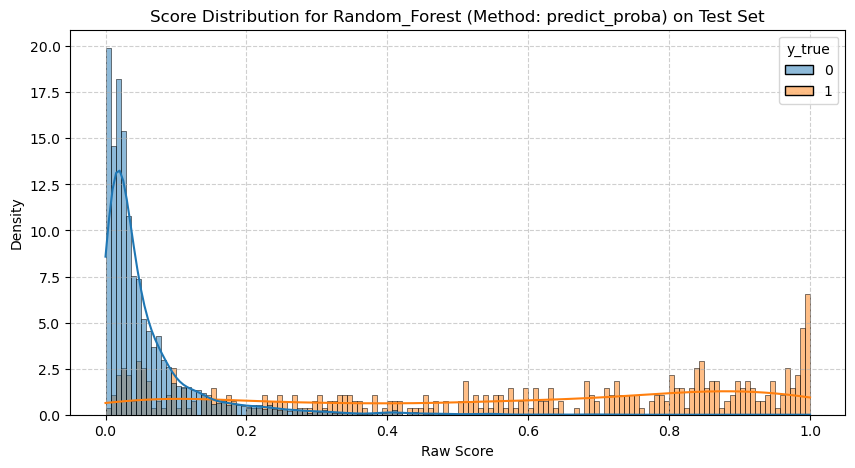


--- Analyzing scores for: SVM ---


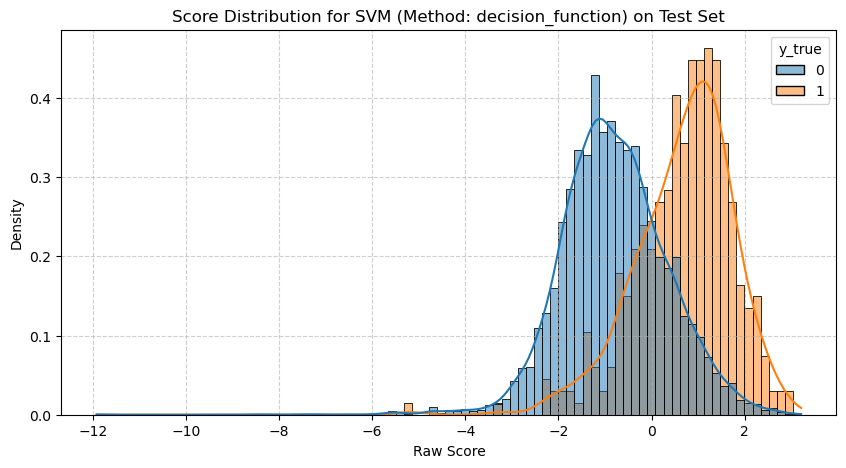


--- Analyzing scores for: XGBoost ---


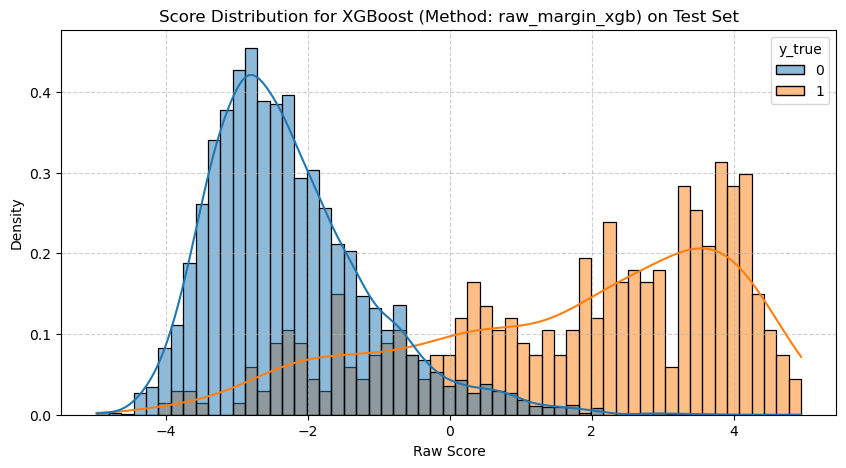

In [110]:
# ==============================================================================
#           DEBUGGING CELL 1: VISUALIZE SCORE DISTRIBUTIONS
# ==============================================================================
models_to_inspect = {
    "Random_Forest": 'predict_proba',
    "SVM": 'decision_function',
    "XGBoost": 'raw_margin_xgb'
}

for model_name, score_method in models_to_inspect.items():
    print(f"\n--- Analyzing scores for: {model_name} ---")

    # Load the pre-trained CVAP predictor
    cvap_predictor = load_predictor(MODEL_DIR, model_name, GROUP_NAME_TO_TEST, 'cvap')
    
    if cvap_predictor is None:
        print(f"Could not load CVAP predictor for {model_name}. Skipping.")
        continue

    # Get the final fitted base estimator
    estimator = cvap_predictor.final_estimator_
    
    # Use appropriate data (scaled for SVM)
    X_test_current = X_test_scaled if model_name == 'SVM' else X_test

    # Get raw scores for the test set
    try:
        raw_scores = cvap_predictor._get_raw_scores(X_test_current)
    except Exception as e:
        print(f"Error getting scores for {model_name}: {e}")
        continue

    # Create a plot
    plt.figure(figsize=(10, 5))
    plot_df = pd.DataFrame({'score': raw_scores, 'y_true': y_test})
    
    sns.histplot(data=plot_df, x='score', hue='y_true', kde=True, stat='density', common_norm=False)
    plt.title(f'Score Distribution for {model_name} (Method: {score_method}) on Test Set')
    plt.xlabel('Raw Score')
    plt.ylabel('Density')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

In [111]:
# ==============================================================================
#      DEBUGGING CELL 2: TEST LOGIT TRANSFORM FOR RANDOM FOREST
# ==============================================================================
MODEL_NAME_TO_TEST = 'Random_Forest'

print(f"\n--- Testing Logit Transform for: {MODEL_NAME_TO_TEST} ---")
cvap_predictor = load_predictor(MODEL_DIR, MODEL_NAME_TO_TEST, GROUP_NAME_TO_TEST, 'cvap')

if cvap_predictor:
    # 1. Get original probabilities from the final estimator
    proba_scores = cvap_predictor.final_estimator_.predict_proba(X_test)[:, 1]

    # 2. Apply the logit transform to get unbounded scores
    # Add a small epsilon for numerical stability
    epsilon = 1e-9
    logit_scores = np.log((proba_scores + epsilon) / (1 - proba_scores + epsilon))
    
    # 3. Use the original per-fold calibrators to predict with these NEW scores
    p0_cols, p1_cols = [], []
    for va in cvap_predictor.calibrators_:
        # Use the standalone calc_probs function with the new scores
        # Note: va.predict_proba does the same, but this is more explicit
        _, bounds = calc_probs(va.p0_, va.p1_, va.c_, logit_scores)
        p0_cols.append(bounds[:, 0])
        p1_cols.append(bounds[:, 1])

    # 4. Aggregate the bounds using the original aggregation method
    p0_stack = np.column_stack(p0_cols)
    p1_stack = np.column_stack(p1_cols)
    p1_final_logit = np.clip(cvap_predictor._aggregate(p0_stack, p1_stack), 0.0, 1.0)
    
    # 5. Evaluate and Compare
    print("\n--- Original CVAP Results (0.5 threshold) ---")
    original_proba = cvap_predictor.predict_proba(X_test)[:, 1]
    original_pred = (original_proba >= 0.5).astype(int)
    original_metrics = calculate_metrics(y_test, original_pred, original_proba)
    print(pd.DataFrame([original_metrics]))

    print("\n--- Logit-Transformed CVAP Results (0.5 threshold) ---")
    logit_pred = (p1_final_logit >= 0.5).astype(int)
    logit_metrics = calculate_metrics(y_test, logit_pred, p1_final_logit)
    print(pd.DataFrame([logit_metrics]))


--- Testing Logit Transform for: Random_Forest ---

--- Original CVAP Results (0.5 threshold) ---
   accuracy  precision  recall  f1_score  specificity  roc_auc  brier_score  \
0    0.9310     1.0000  0.0182    0.0357       1.0000   0.8773       0.0619   

   TP   FN  FP    TN  
0   7  378   0  5093  

--- Logit-Transformed CVAP Results (0.5 threshold) ---
   accuracy  precision  recall  f1_score  specificity  roc_auc  brier_score  \
0    0.9580     0.9814  0.4104    0.5788       0.9994   0.7998       0.0405   

    TP   FN  FP    TN  
0  158  227   3  5090  


In [ ]:
# ==============================================================================
#           DEBUGGING CELL 3: TEST RANK TRANSFORM FOR SVM SCORES
# ==============================================================================
from scipy.stats import rankdata

MODEL_NAME_TO_TEST = 'SVM'

print(f"\n--- Testing Rank Transform for: {MODEL_NAME_TO_TEST} ---")
cvap_predictor = load_predictor(MODEL_DIR, MODEL_NAME_TO_TEST, GROUP_NAME_TO_TEST, 'cvap')

if cvap_predictor:
    # Use the correctly scaled test data for SVM
    X_test_current = X_test_scaled

    # 1. Get original decision function scores from the final estimator
    decision_scores = cvap_predictor._get_raw_scores(X_test_current)

    # 2. Apply the Rank Transform
    # rankdata converts each score to its rank in the flattened array.
    # This creates a uniform distribution of scores.
    rank_scores = rankdata(decision_scores)
    
    # 3. Use the original per-fold calibrators to predict with these NEW rank scores
    p0_cols, p1_cols = [], []
    for va in cvap_predictor.calibrators_:
        _, bounds = calc_probs(va.p0_, va.p1_, va.c_, rank_scores)
        p0_cols.append(bounds[:, 0])
        p1_cols.append(bounds[:, 1])

    # 4. Aggregate the bounds using the original aggregation method
    p0_stack = np.column_stack(p0_cols)
    p1_stack = np.column_stack(p1_cols)
    p1_final_rank = np.clip(cvap_predictor._aggregate(p0_stack, p1_stack), 0.0, 1.0)
    
    # 5. Evaluate and Compare
    print("\n--- Original CVAP Results (0.5 threshold) ---")
    original_proba = cvap_predictor.predict_proba(X_test_current)[:, 1]
    original_pred = (original_proba >= 0.5).astype(int)
    original_metrics = calculate_metrics(y_test, original_pred, original_proba)
    print(pd.DataFrame([original_metrics]))

    print("\n--- Rank-Transformed CVAP Results (0.5 threshold) ---")
    rank_pred = (p1_final_rank >= 0.5).astype(int)
    rank_metrics = calculate_metrics(y_test, rank_pred, p1_final_rank)
    print(pd.DataFrame([rank_metrics]))


--- Testing Rank Transform for: SVM ---

--- Original CVAP Results (0.5 threshold) ---
   accuracy  precision  recall  f1_score  specificity  roc_auc  brier_score  \
0    0.9284     0.3793  0.0286    0.0531       0.9965   0.8276       0.0591   

   TP   FN  FP    TN  
0  11  374  18  5075  

--- Rank-Transformed CVAP Results (0.5 threshold) ---
   accuracy  precision  recall  f1_score  specificity  roc_auc  brier_score  \
0    0.0706     0.0703  1.0000    0.1314       0.0004   0.5003       0.9294   

    TP  FN    FP  TN  
0  385   0  5091   2  


In [114]:
# ==============================================================================
#      DEBUGGING CELL 6 (Corrected): TESTING RANK TRANSFORM FOR SVM
# ==============================================================================
from scipy.stats import rankdata

MODEL_NAME_TO_TEST = 'SVM'

print(f"\n--- Correctly Testing Rank Transform for: {MODEL_NAME_TO_TEST} ---")

# --- Step 1: Get best params and instantiate the base estimator ---
params_filepath = os.path.join(BEST_PARAMS_DIR, f"{GROUP_NAME_TO_TEST}_best_params.json")
with open(params_filepath, 'r') as f:
    all_best_params = json.load(f)
best_params = all_best_params.get(MODEL_NAME_TO_TEST)

if not best_params:
    print(f"No best params found for {MODEL_NAME_TO_TEST}. Aborting.")
else:
    # Use scaled data for SVM
    X_train_current, X_test_current = X_train_scaled, X_test_scaled
    
    # <-- CORRECTED LINE: Update the dictionary to ensure keys are unique
    best_params.update({'probability': True, 'random_state': RANDOM_SEED})
    base_estimator = SVC(**best_params)

    # --- Step 2: Build K calibrators using RANKED out-of-fold (OOF) scores ---
    print("Building per-fold calibrators on RANKED OOF scores...")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    calibrators = []

    for train_idx, val_idx in tqdm(cv.split(X_train_current, y_train), total=5, desc="CV Folds"):
        est = clone(base_estimator).fit(X_train_current[train_idx], y_train.iloc[train_idx])
        
        # Get original OOF scores
        oof_scores = est.decision_function(X_train_current[val_idx])
        # RANK TRANSFORM the OOF scores
        ranked_oof_scores = rankdata(oof_scores)
        
        # Fit a calibrator on the RANKED scores
        va = RawVennAbers().fit(ranked_oof_scores, y_train.iloc[val_idx])
        calibrators.append(va)

    # --- Step 3: Fit a final base model ---
    print("Fitting final base model on all training data...")
    final_estimator = clone(base_estimator).fit(X_train_current, y_train)

    # --- Step 4: Predict on the test set using a CONSISTENT rank transform ---
    # Get original test scores
    test_scores = final_estimator.decision_function(X_test_current)
    # RANK TRANSFORM the test scores
    ranked_test_scores = rankdata(test_scores)
    
    # Predict using the calibrators that were trained on ranks
    p0_cols, p1_cols = [], []
    for va in calibrators:
        _, bounds = calc_probs(va.p0_, va.p1_, va.c_, ranked_test_scores)
        p0_cols.append(bounds[:, 0])
        p1_cols.append(bounds[:, 1])

    # Aggregate using the same logic as the original CVAP predictor
    p0_stack = np.column_stack(p0_cols)
    p1_stack = np.column_stack(p1_cols)
    # Use the aggregation logic from CVAPPredictorRaw (assuming 'log' loss)
    g1 = np.exp(np.mean(np.log(np.clip(p1_stack, 1e-9, 1.0)), axis=1))
    g0 = np.exp(np.mean(np.log(np.clip(1.0 - p0_stack, 1e-9, 1.0)), axis=1))
    denom = g0 + g1
    p1_final_rank = np.where(denom > 0, g1 / denom, 0.5)

    # --- Step 5: Evaluate and Compare ---
    print("\n--- Original CVAP Results (0.5 threshold) ---")
    original_predictor = load_predictor(MODEL_DIR, MODEL_NAME_TO_TEST, GROUP_NAME_TO_TEST, 'cvap')
    if original_predictor:
        original_proba = original_predictor.predict_proba(X_test_current)[:, 1]
        original_pred = (original_proba >= 0.5).astype(int)
        original_metrics = calculate_metrics(y_test, original_pred, original_proba)
        print(pd.DataFrame([original_metrics]))

    print(f"\n--- Correctly Rank-Transformed CVAP Results (0.5 threshold) ---")
    rank_pred = (p1_final_rank >= 0.5).astype(int)
    rank_metrics = calculate_metrics(y_test, rank_pred, p1_final_rank)
    print(pd.DataFrame([rank_metrics]))


--- Correctly Testing Rank Transform for: SVM ---
Building per-fold calibrators on RANKED OOF scores...


CV Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting final base model on all training data...

--- Original CVAP Results (0.5 threshold) ---
   accuracy  precision  recall  f1_score  specificity  roc_auc  brier_score  \
0    0.9284     0.3793  0.0286    0.0531       0.9965   0.8276       0.0591   

   TP   FN  FP    TN  
0  11  374  18  5075  

--- Correctly Rank-Transformed CVAP Results (0.5 threshold) ---
   accuracy  precision  recall  f1_score  specificity  roc_auc  brier_score  \
0    0.7397     0.1866  0.8052    0.3030       0.7347   0.7956       0.2717   

    TP  FN    FP    TN  
0  310  75  1351  3742  


In [4]:
# ==============================================================================
#      DEBUGGING CELL 2 (CORRECTED): RETRAIN CVAP WITH LOGIT SCORES
# ==============================================================================
MODEL_NAME_TO_TEST = 'Random_Forest'

print(f"\n--- Retraining CVAP from scratch for '{MODEL_NAME_TO_TEST}' using logit-transformed scores ---")

# --- Step 1: Get best params and instantiate the base estimator ---
params_filepath = os.path.join(BEST_PARAMS_DIR, f"{GROUP_NAME_TO_TEST}_best_params.json")
try:
    with open(params_filepath, 'r') as f:
        all_best_params = json.load(f)
    best_params = all_best_params.get(MODEL_NAME_TO_TEST)
    if not best_params:
        raise FileNotFoundError
except (FileNotFoundError, KeyError):
    print(f"FATAL: No best params found for {MODEL_NAME_TO_TEST} in {params_filepath}. Aborting.")
    best_params = None

if best_params:
    # --- FIX IS HERE ---
    # Modify the params dictionary directly to avoid providing duplicate keyword arguments.
    # This ensures 'random_state' and 'n_jobs' are set correctly before unpacking.
    best_params['random_state'] = RANDOM_SEED
    best_params['n_jobs'] = -1
    
    # Now, instantiate the classifier by only unpacking the prepared dictionary.
    base_estimator = RandomForestClassifier(**best_params)
    
    # --- Step 2: Regenerate OOF scores, applying the logit transform ---
    print("Generating out-of-fold logit scores...")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    oof_logit_scores_list, oof_y_list = [], []
    epsilon = 1e-9 # For numerical stability

    for fold, (train_idx, val_idx) in enumerate(tqdm(cv.split(X_train, y_train), total=5, desc="CV Folds")):
        est = clone(base_estimator).fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
        
        # Get probabilities on the validation part of the fold
        proba_scores = est.predict_proba(X_train.iloc[val_idx])[:, 1]
        
        # <<< CRITICAL CHANGE: Apply logit transform before storing >>>
        logit_scores = np.log((proba_scores + epsilon) / (1 - proba_scores + epsilon))
            
        oof_logit_scores_list.append(logit_scores)
        oof_y_list.append(y_train.iloc[val_idx])

    # --- Step 3: Fit K new RawVennAbers calibrators on the logit scores ---
    print("Fitting K VennAbers calibrators on the new logit scores...")
    logit_trained_calibrators = [
        RawVennAbers().fit(scores, y_cal)
        for scores, y_cal in zip(oof_logit_scores_list, oof_y_list)
    ]
    print(f"Successfully trained {len(logit_trained_calibrators)} new calibrators.")

    # --- Step 4: Fit a final base model on all training data ---
    print("Fitting final base model on all training data...")
    final_estimator = clone(base_estimator).fit(X_train, y_train)

    # --- Step 5: Evaluate the new "Logit-Trained CVAP" on the test set ---
    # We manually replicate the prediction process of CVAPPredictorRaw
    
    # 5a. Get probabilities from the final model and transform to logits
    test_proba = final_estimator.predict_proba(X_test)[:, 1]
    test_logit_scores = np.log((test_proba + epsilon) / (1 - test_proba + epsilon))
    
    # 5b. Get bounds from each of our newly trained calibrators
    p0_cols, p1_cols = [], []
    for va in logit_trained_calibrators:
        _, bounds = calc_probs(va.p0_, va.p1_, va.c_, test_logit_scores)
        p0_cols.append(bounds[:, 0])
        p1_cols.append(bounds[:, 1])
    
    # 5c. Aggregate the bounds to get the final probability
    p0_stack = np.column_stack(p0_cols)
    p1_stack = np.column_stack(p1_cols)
    # The aggregation formula is copied from CVAPPredictorRaw for log loss
    g1 = np.exp(np.mean(np.log(np.clip(p1_stack, 1e-9, 1.0)), axis=1))
    g0 = np.exp(np.mean(np.log(np.clip(1.0 - p0_stack, 1e-9, 1.0)), axis=1))
    denom = g0 + g1
    p1_final_logit_trained = np.where(denom > 0, g1 / denom, 0.5)
    
    # --- Step 6: Compare with the original CVAP model ---
    print("\n" + "="*50)
    print("                      RESULTS COMPARISON")
    print("="*50)
    
    # Load and evaluate the original pre-trained model
    print("\n--- Original CVAP Results (trained on probabilities) ---")
    original_predictor = load_predictor(MODEL_DIR, MODEL_NAME_TO_TEST, GROUP_NAME_TO_TEST, 'cvap')
    if original_predictor:
        original_proba = original_predictor.predict_proba(X_test)[:, 1]
        original_pred = (original_proba >= 0.5).astype(int)
        original_metrics = calculate_metrics(y_test, original_pred, original_proba)
        display(pd.DataFrame([original_metrics]))
    else:
        print("Original predictor not found.")

    # Evaluate our newly trained model
    print("\n--- NEW Logit-Trained CVAP Results (trained on logits) ---")
    logit_trained_pred = (p1_final_logit_trained >= 0.5).astype(int)
    logit_trained_metrics = calculate_metrics(y_test, logit_trained_pred, p1_final_logit_trained)
    display(pd.DataFrame([logit_trained_metrics]))


--- Retraining CVAP from scratch for 'Random_Forest' using logit-transformed scores ---
Generating out-of-fold logit scores...


CV Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting K VennAbers calibrators on the new logit scores...
Successfully trained 5 new calibrators.
Fitting final base model on all training data...

                      RESULTS COMPARISON

--- Original CVAP Results (trained on probabilities) ---


,accuracy,precision,recall,f1_score,specificity,roc_auc,brier_score,TP,FN,FP,TN
0,0.930997,1.0,0.018182,0.035714,1.0,0.877341,0.061918,7,378,0,5093



--- NEW Logit-Trained CVAP Results (trained on logits) ---


,accuracy,precision,recall,f1_score,specificity,roc_auc,brier_score,TP,FN,FP,TN
0,0.930632,1.0,0.012987,0.025641,1.0,0.851194,0.063023,5,380,0,5093
